## Libraries

In [1]:
mogp_dir <- "/data/rlguensat/conda_envs/envHM/lib/python3.8/site-packages/mogp_emulator"
## important to add "import warning" at MutliOutputGP.py

setwd('..')

source('ExeterUQ_MOGP/BuildEmulator/BuildEmulator.R')
source('ExeterUQ_MOGP/HistoryMatching/HistoryMatching.R')
#source("HistoryMatching/impLayoutplot.R")
source('ExeterUQ_MOGP/BuildEmulator/utils.R')

library(comprehenr)
library(caret, include.only = 'preProcess')
library("future.apply") #important for parallel version of ImplausibilityMOGP function in HistoryMatching.R

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: ‘maps’


The following object is masked from ‘package:viridis’:

    unemp


This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORE

# Read data 

In [2]:
my_bounds <- data.frame(c(-2, 2), c(-20, 20), c(1, 20), c(-20, 20))

In [3]:
set.seed(42)
inputs <- as.data.frame(2*maximinLHS(40, 4)-1)
inputs_unscaled <- rangeUnscale(inputs, my_bounds)
names(inputs) <- c('h','F','c','b')
names(inputs_unscaled) <- c('h','F','c','b')
inputs_unscaled

h,F,c,b
<dbl>,<dbl>,<dbl>,<dbl>
-0.95065370,-11.2562260,4.229452,-9.9531360
-0.58927492,5.8830426,13.898875,-11.6106726
1.39206032,0.9462625,16.877577,-3.7154909
1.02402020,-9.7429115,9.641193,-18.7297420
1.16535190,-7.7847999,11.308971,8.5762092
-0.21157391,10.2084259,7.555337,-2.3705134
0.68887439,16.1883815,9.057361,9.3133691
1.59755322,-18.8017093,6.722807,-6.3112822
-0.15179771,15.1417445,16.473220,12.5323920


In [4]:
write.csv(inputs_unscaled,"Data/df_inputs_newPCA_wave1.csv", row.names = FALSE)

### Please move to the Python notebook to run the L96 and get metrics then come back

In [5]:
set.seed(42)
                       
#Load outputs and select variables you want to keep
outputs <- read.csv("Data/df_metrics_newPCA_wave1.csv")
                         
#Add some noise (here no noise added)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4753268,-0.56281130,-0.66005764,-0.4976568,0.68547922,-1.8811279,-2.587089,7.0579560,4.7629763,-2.3701552,1.39352289,-2.5536990,0.9045056
2,-0.2946375,0.29415213,0.35777631,-0.5805336,-0.28234909,-0.2327028,-3.483759,-0.9372659,-4.4485803,2.1008725,0.68989426,0.2348095,-0.4686630
3,0.6960302,0.04731313,0.67132394,-0.1857745,0.18156421,-5.9452101,-3.315966,0.8331088,-2.9057183,1.4739491,0.14935405,-0.7245966,-0.3436172
4,0.5120101,-0.48714557,-0.09040072,-0.9364871,0.31643130,-5.2922827,-0.642532,-0.2529432,0.5559772,-4.6481555,-1.29990097,1.1870957,-0.1011811
5,0.5826760,-0.38923999,0.08515486,0.4288105,0.20213416,-5.8250171,-1.254328,4.7497049,1.2127406,1.9638641,2.16796618,4.6771778,3.7979063
6,-0.1057870,0.51042130,-0.30996449,-0.1185257,-0.05306226,10.5390520,0.961140,4.2461494,-8.8237176,0.2665562,-0.08935231,1.3575437,-0.7595904


### Training Emulators

In [6]:
TestEm <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line
                            #Choices = lapply(1:length(outputs), function(k) choices.new))

[1] "Max reduction is 1.75535449793424 using F"
[1] "Max reduction is 2.30235868218876 using F"
[1] "Max reduction is 0.174702075729308 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = pca_0 ~ F + I(F^2) + c + I(c * F), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0098 -0.9786  0.1288  1.9798  7.3873 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.1017     0.8304  -6.144 4.99e-07 ***
F             8.5972     0.9536   9.016 1.19e-10 ***
I(F^2)       15.4083     1.8741   8.222 1.09e-09 ***
c            -2.0285     0.9503  -2.135   0.0399 *  
I(c * F)     -2.1832     1.8089  -1.207   0.2356    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.476 on 35 degrees of freedom
Multiple R-squared:  0.8175,	Adjusted R-squared:  0.7967 
F-statistic:  39.2 on 4 and 35 DF,  p-value: 1.805e-12

[1] "Max reduction is 0.356689239703845 using F"
[1] "Max reduction is 0.4948229

In [7]:
tDisc <- rep(0, length(outputs))
tObs <- read.csv("Data/df_obs_nonoise_newPCA_wave1.csv")
tObs <- as.vector(t(tObs))
tObsErr <- rep(0, length(outputs))

## LOO

In [8]:
cands <- names(tData)[1:4]

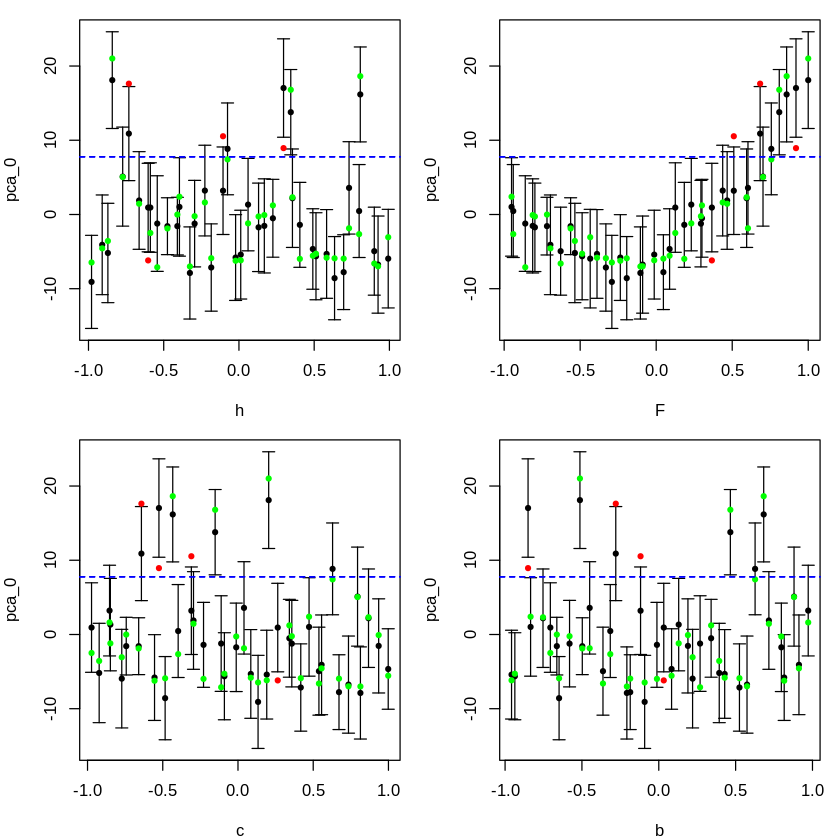

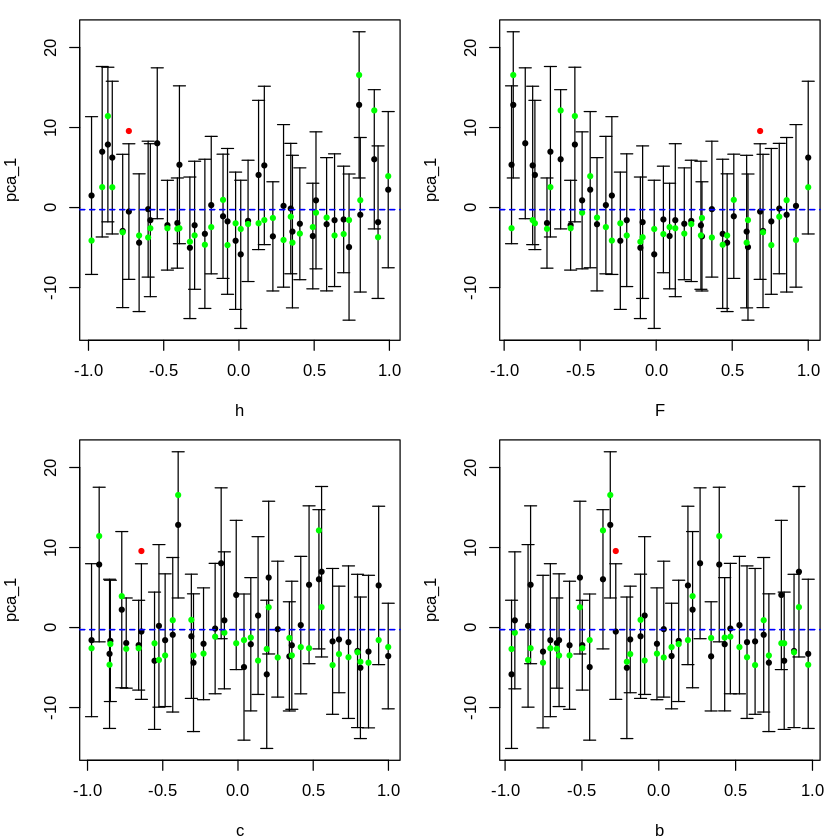

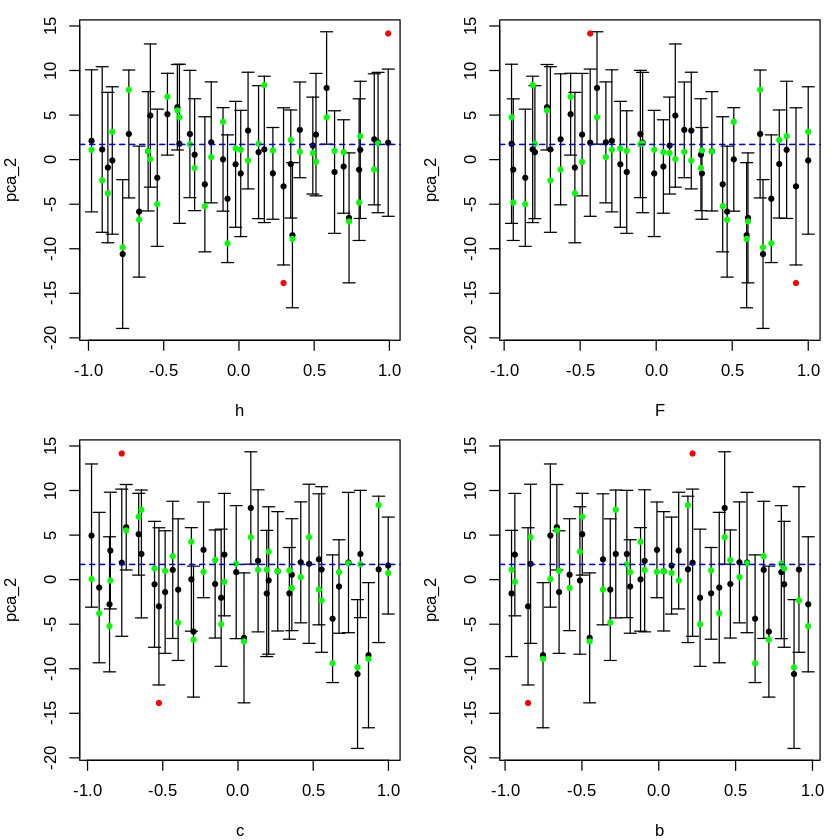

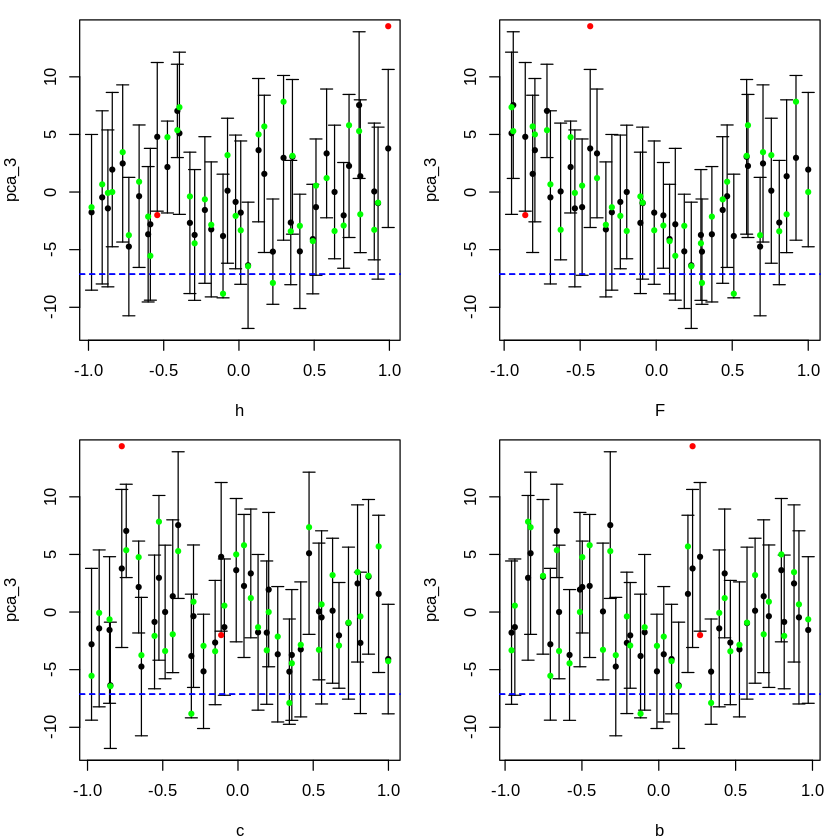

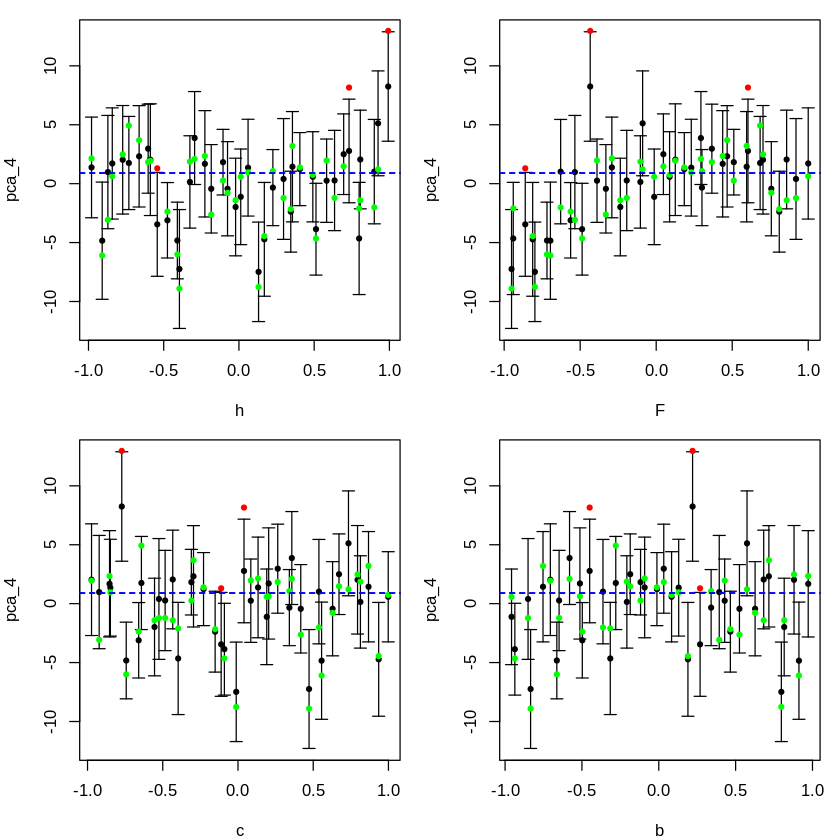

In [11]:
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 3, ParamNames = cands, Obs = tObs[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 4, ParamNames = cands, Obs = tObs[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 5, ParamNames = cands, Obs = tObs[5], ObsErr = 0.)#tLOOs <- 

## History Matching
* Observations discrepancy variances in *tDisc* (here sets to 0)
* Observations errors in *tObsErr* (here set to 0)

In [12]:
future::availableCores() 

system 
    48

In [13]:
set.seed(42)
sample_size <- 1000000
nparam <- length(names(TestEm$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(TestEm$fitting.elements$Design)

In [14]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 17.486  20.165   6.084 

In [15]:
ImpData_wave1 = cbind(Xp, Timps)
print(object.size(ImpData_wave1), units="Mb")

91.6 Mb


In [16]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off?
cutoff_vec <- 3 #the implausibility cut off

param.def = data.frame(h=c(1), F=c(10), c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h   F           c   b
1 0.5 0.5 -0.05263158 0.5


In [17]:
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=TestEm$mogp$n_emulators, whichMax=valmax+1)
NROY1 <- which(rowSums(Timps <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
ratio1 <- length(NROY1)/dim(Xp)[1]
ratio1

[1] 0.16956

#### 40 samples for training, 1 000 000 points for test

In [18]:
#png("InputSpace_wave_1.png", res = 110)
#imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title="InputSpace_wave.pdf",newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
#mtext(paste("Remaining space:",length(NROY1)/dim(Xp)[1],sep=""), side=1)
#dev.off()

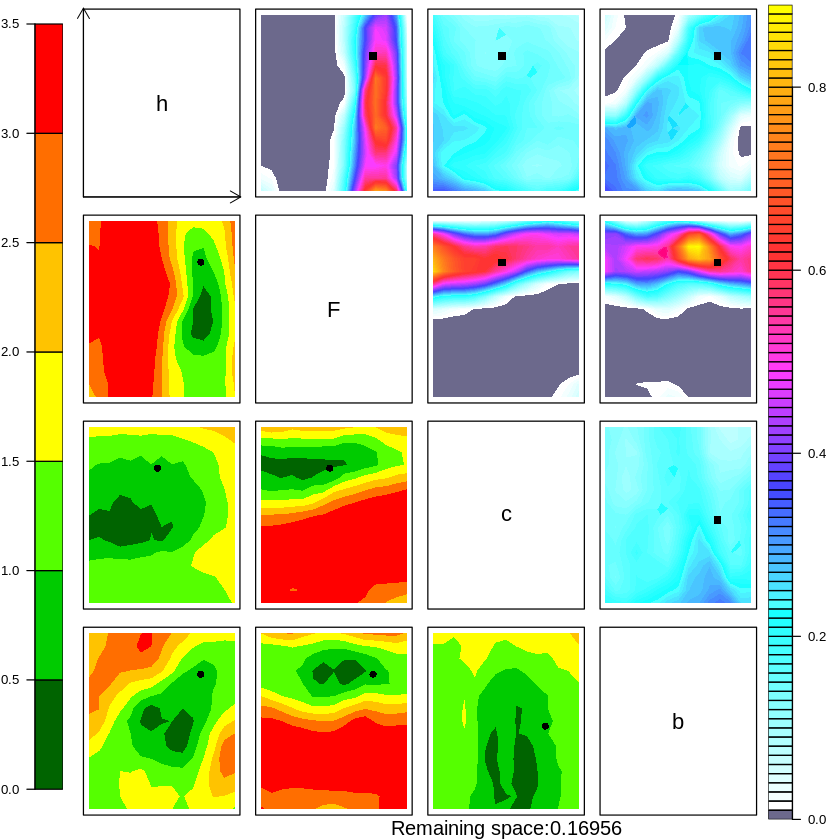

In [19]:
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY1)/dim(Xp)[1],sep=""), side=1)

# Wave2

In [20]:
40/ratio1

[1] 235.9047

In [21]:
set.seed(42)

designpoints <- data.frame()

while (nrow(designpoints) <= 40) {
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio1), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        selectionP <- tmp[NROYtmp,]
        row.names(selectionP) <- NULL ## to avoid double index
        designpoints <- rbind(designpoints,selectionP)
        print(nrow(designpoints))
        flush.console()
        } 

designpoints <- designpoints[sample(nrow(designpoints),40),]

designpoints_denorm <- rangeUnscale(designpoints, my_bounds)

[1] 36
[1] 72


In [22]:
designpoints_denorm

,h,F,c,b
,<dbl>,<dbl>,<dbl>,<dbl>
6,0.65260919,8.7444024,7.970611,14.33900653
69,-0.59266870,16.3142401,11.783022,-15.86725055
20,1.32027792,13.2194937,7.158078,3.05887005
13,-1.65198912,14.6733204,11.998126,-0.56830894
15,0.50161216,12.2362421,12.233123,5.84063988
12,-0.33240449,12.8414706,3.813505,-6.73299015
48,-1.13902555,5.9950119,5.128210,-17.12218507
72,-1.98400823,14.6131678,4.565434,-14.62789432
34,-1.90144003,0.2901693,3.209847,-0.22141087


In [23]:
write.csv(designpoints_denorm,"Data/exp_TuningL94_newPCA_wave2.csv", row.names = FALSE)

#### please go back to the Python notebook

In [24]:
inputs <- designpoints

#Load outputs and select variables you want to keep
outputs <- read.csv("Data/df_metrics_newPCA_wave2.csv")
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0.3263046,0.4372201,-0.2662515,0.71695033,0.68547922,5.033960,-2.9853227,-0.7721204,-5.131018,0.74777303,1.2121444,1.1665757,-0.5560013
69,-0.2963344,0.8157120,0.1350550,-0.79336253,-0.28234909,12.690021,-4.7612641,-4.2549197,1.220193,-2.28488524,3.3362800,1.6179492,-0.4589428
20,0.6601390,0.6609747,-0.3517813,0.15294350,0.18156421,11.641246,18.3299710,6.5153591,-17.661851,1.35995850,-10.4426771,2.8271955,-1.1626176
13,-0.8259946,0.7336660,0.1576974,-0.02841545,0.31643130,-5.159685,-1.5505181,0.6615441,-5.499084,0.10289364,-0.6269632,0.6584065,-0.8225995
15,0.2508061,0.6118121,0.1824340,0.29203199,0.20213416,11.875390,0.5906834,3.8024996,-8.144226,-0.01036346,0.3106346,1.3854590,-0.6805831
12,-0.1662022,0.6420735,-0.7038415,-0.33664951,-0.05306226,10.431280,-3.3850738,-1.0328113,-2.621731,-0.95866844,2.2963115,1.3446483,-0.5266399


In [25]:
TestEm2 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 1.83038781963219 using F"
[1] "Max reduction is 0.528667540300481 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = pca_0 ~ F + c + I(c * F), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6496  -0.7568   0.6021   2.4712   6.7324 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -10.414      2.768  -3.762   0.0006 ***
F             27.997      4.559   6.141  4.5e-07 ***
c             -6.141      4.571  -1.343   0.1875    
I(c * F)       2.870      7.393   0.388   0.7001    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.552 on 36 degrees of freedom
Multiple R-squared:  0.5996,	Adjusted R-squared:  0.5662 
F-statistic: 17.97 on 3 and 36 DF,  p-value: 2.696e-07

[1] "Max reduction is 0.0882401763598502 using F"
[1] "Max reduction is 0.155041114951215 using F"
[1] "Max reduction is 0.059819469585924 using h"
[1] "Max reduction is 0.03087655

In [26]:
tObs2 <- read.csv("Data/df_obs_nonoise_newPCA_wave1.csv")
tObs2 <- as.vector(t(tObs2)) ############## no chnage in obs in waves

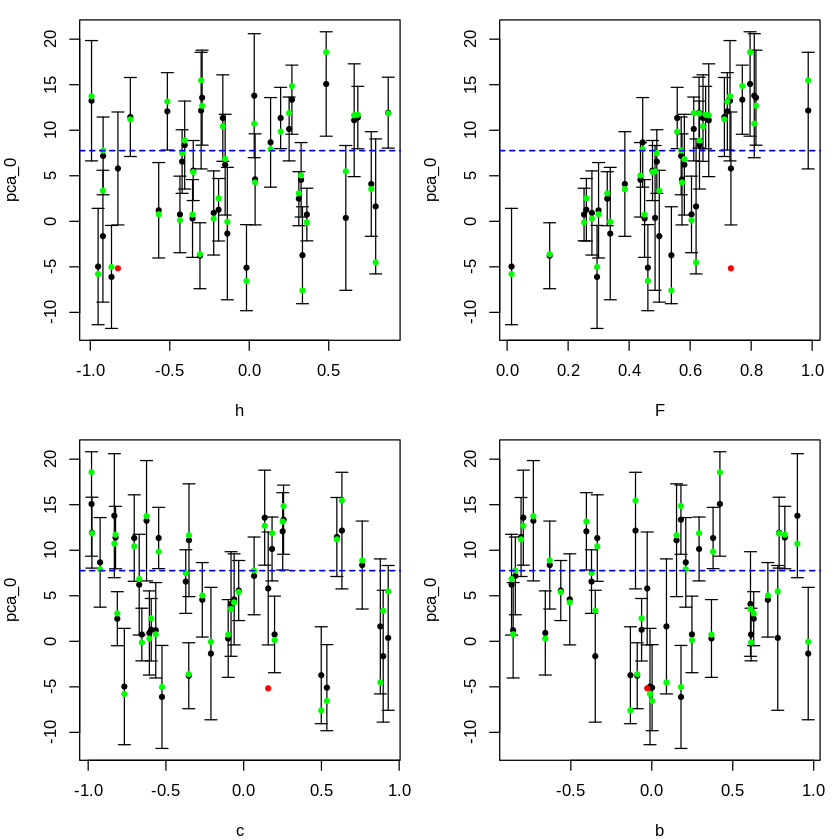

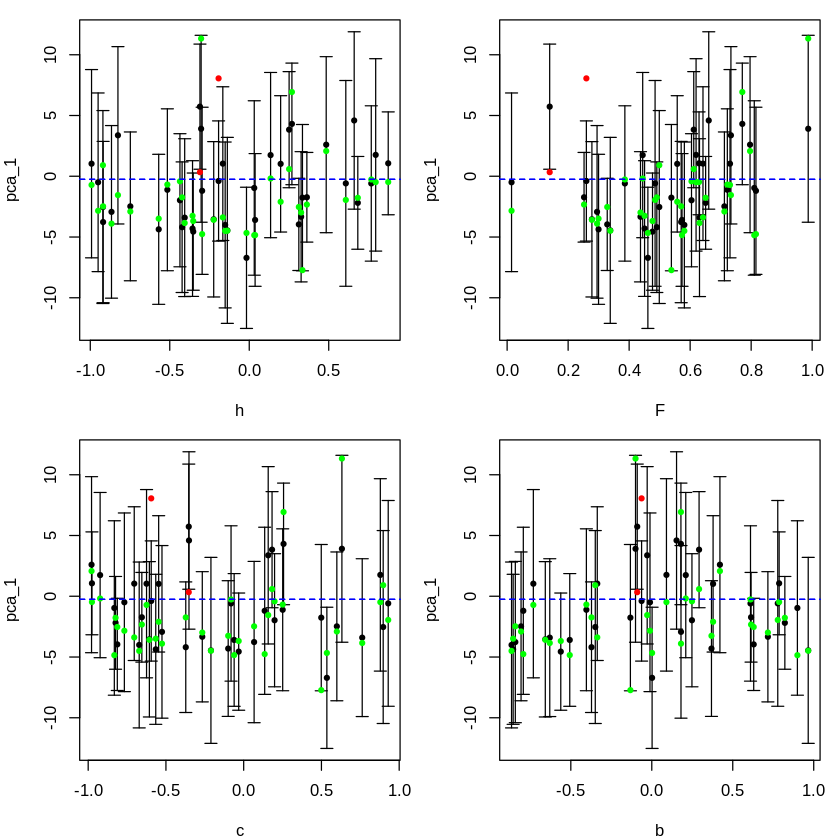

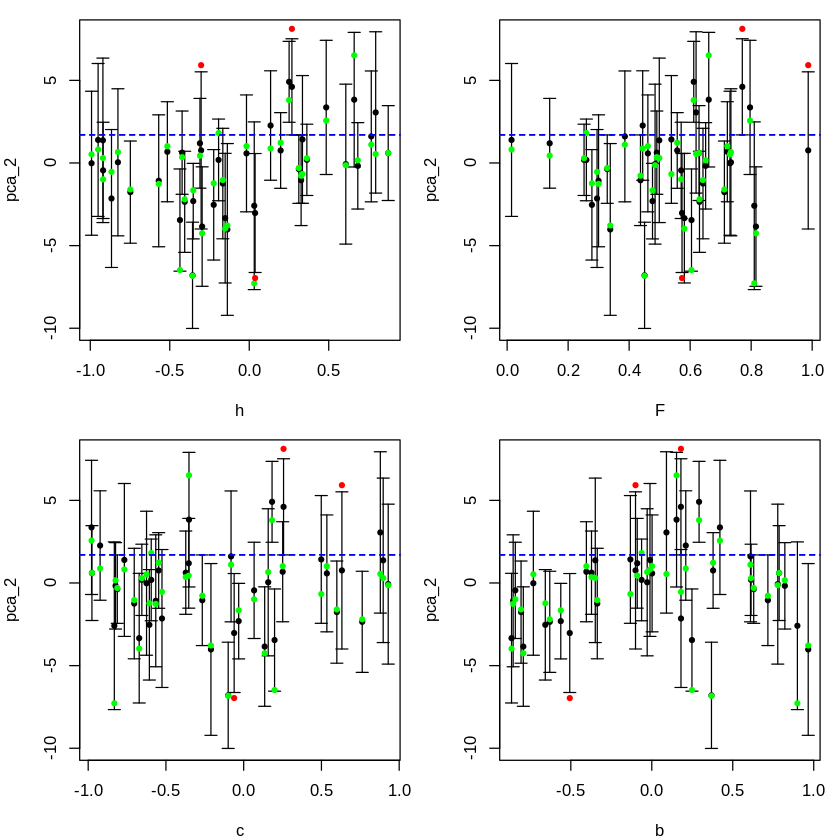

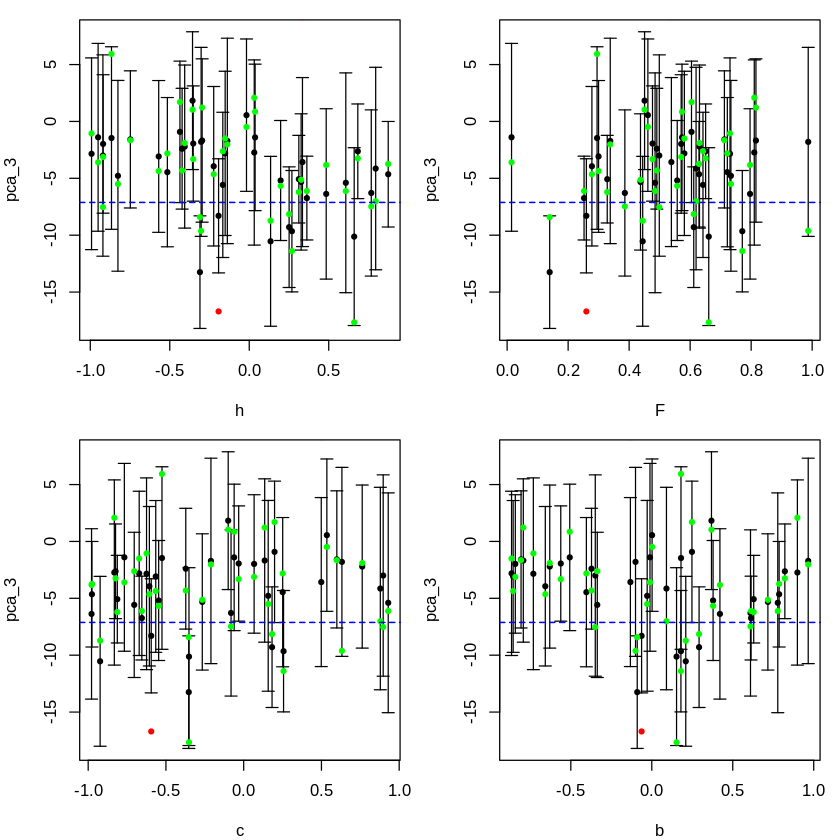

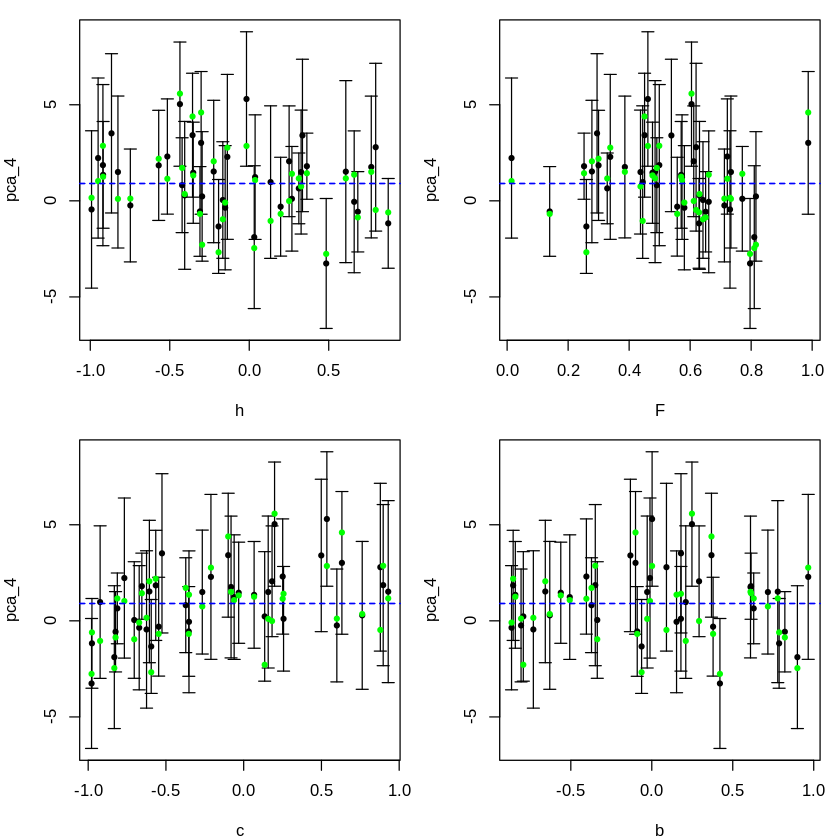

In [27]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [28]:
Timps2 <- matrix(rep(t(Timps),1), ncol=ncol(Timps), byrow=TRUE)
system.time(Timps2[NROY1,] <- ImplausibilityMOGP(NewData=Xp[NROY1,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs2, ObsErr=tObsErr))

   user  system elapsed 
  2.369   3.341   1.428 

In [29]:
#tracemem(Timps2) == tracemem(Timps)

In [30]:
ImpData_wave2 = cbind(Xp, Timps2)

In [31]:
valmax2 = 0 #how many outputs can be above the implausibility cut off?
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=TestEm2$mogp$n_emulators, whichMax=valmax2+1)
NROY2 <- which(rowSums(Timps2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax2)
ratio2 <- length(NROY2)/dim(Xp)[1]
ratio2

[1] 0.079141

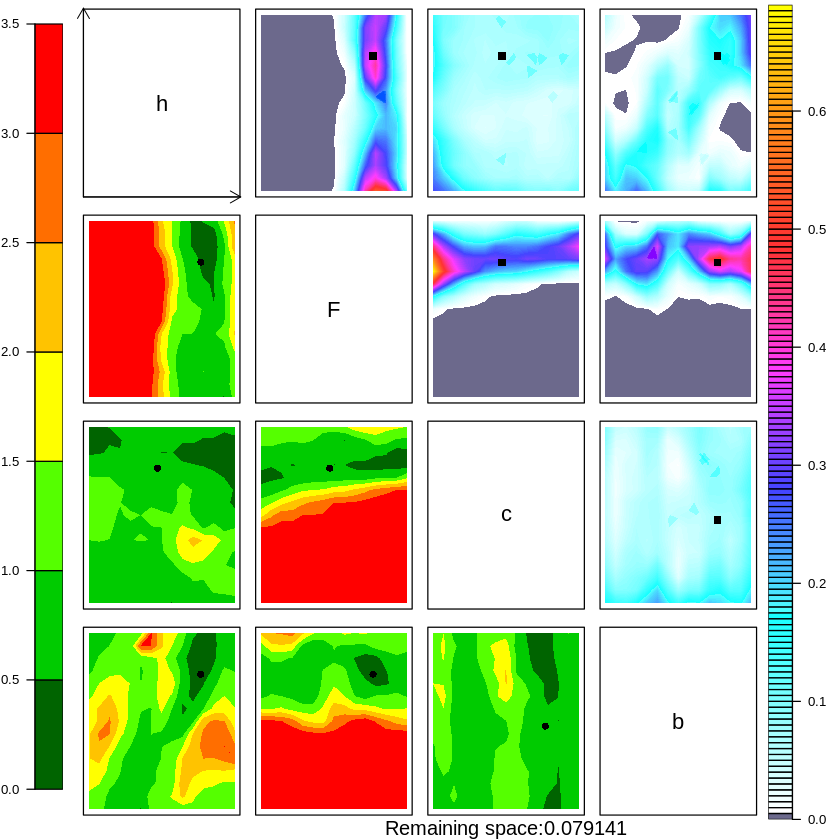

In [32]:
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY2)/dim(Xp)[1],sep=""), side=1)

In [33]:
length(NROY2)

[1] 79141

# Wave 3

In [34]:
40/ratio2

[1] 505.427

In [35]:
set.seed(42)

designpoints2 <- data.frame()

while (nrow(designpoints2) <= 40) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio2), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs2, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints2 <- rbind(designpoints2,selectionP)
        print(nrow(designpoints2))
        flush.console()
        } 

designpoints2 <- designpoints2[sample(nrow(designpoints2),40),]

designpoints_denorm2 <- rangeUnscale(designpoints2, my_bounds)

[1] 33
[1] 67


In [36]:
designpoints_denorm2

,h,F,c,b
,<dbl>,<dbl>,<dbl>,<dbl>
57,-1.987295131,8.121896,14.995013,-15.3526424
16,-1.084196017,10.876909,9.694387,-8.5934575
49,0.732148092,7.548685,1.660643,-6.9507884
48,1.273475781,11.848810,2.357623,12.1246774
36,0.589853571,12.728516,11.065975,-0.8040959
58,0.976078818,6.868409,2.071545,3.2641935
31,1.952709833,7.589909,12.185259,18.7447404
61,1.571528301,8.831054,6.554944,15.2186381
9,0.233628900,7.044919,2.053896,-14.3893503


In [37]:
write.csv(designpoints_denorm2,"Data/exp_TuningL94_newPCA_wave3.csv", row.names = FALSE)

#### you know what to do ;)

In [38]:
inputs <- designpoints2

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_wave3.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,-0.9936476,0.4060948,0.47315922,-0.76763212,0.68547922,2.330974,-2.42500158,-0.5405701,-4.762373,2.3507907,0.3285003,0.2467347,-0.3966515
16,-0.5420980,0.5438454,-0.08480140,-0.42967288,-0.28234909,7.620368,-1.53538937,0.4142762,-3.949834,1.8493103,0.5469290,0.1537670,-0.2291018
49,0.3660740,0.3774343,-0.93045866,-0.34753942,0.18156421,-2.406015,-3.97464352,-7.2165280,5.753859,7.3444256,-0.5269382,-3.4287957,1.1525151
48,0.6367379,0.5924405,-0.85709228,0.60623387,0.31643130,11.913328,-0.02359023,2.1143516,-4.877642,-0.1603107,0.5826657,0.8866911,-0.3895052
36,0.2949268,0.6364258,0.05957633,-0.04020479,0.20213416,-7.342259,-6.49682514,1.2440809,3.965071,5.7075995,1.2836424,-4.6058244,1.0467566
58,0.4880394,0.3434205,-0.88720577,0.16320967,-0.05306226,14.192289,17.98016854,9.3927940,-17.263905,1.1737770,-9.7024081,2.2082644,-0.9962405


In [39]:
TestEm3 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.279525299849849 using h"
[1] "Max reduction is 0.0606470235324421 using b"
[1] "Max reduction is 0.0684214053113816 using c"
[1] "Max reduction is 0.319768519987528 using c"
[1] "Max reduction is 0.00917959186336148 using h"
[1] "Max reduction is 0.0252485691328364 using Three Way Interactions with c"
[1] "Max reduction is 0.0790333641222869 using c"
[1] "Max reduction is 0.0745587852161345 using b"
[1] "Max reduction is 0.191252132011798 using b"
[1] "Max reduction is 0.0139329800995505 using b"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ h + I(h^2) + b + I(b^2) + I(b^3) + I(b^4) + 
    c + I(c^2) + I(c^3) + I(b * h) + I(c * h) + I(c * b) + I(c * 
    b * h) + I(c * c * h) + I(c * c * b), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7266 -2.3510 -0.1221  1.7293  7.6588 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    0.9879     1.6515   0.598  0.55532   
h            -10.2090    

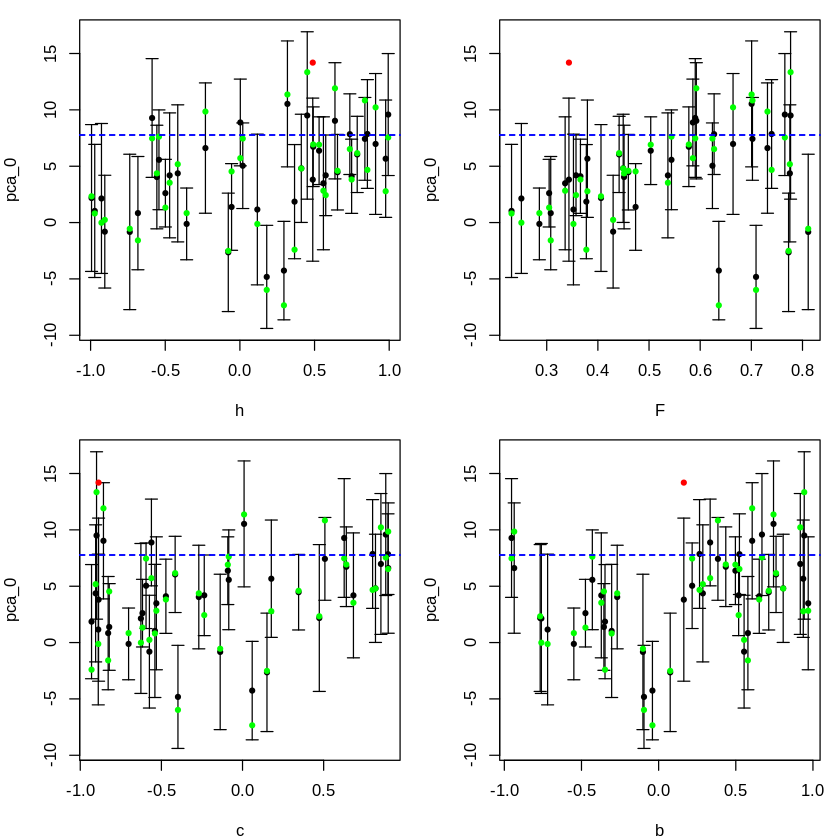

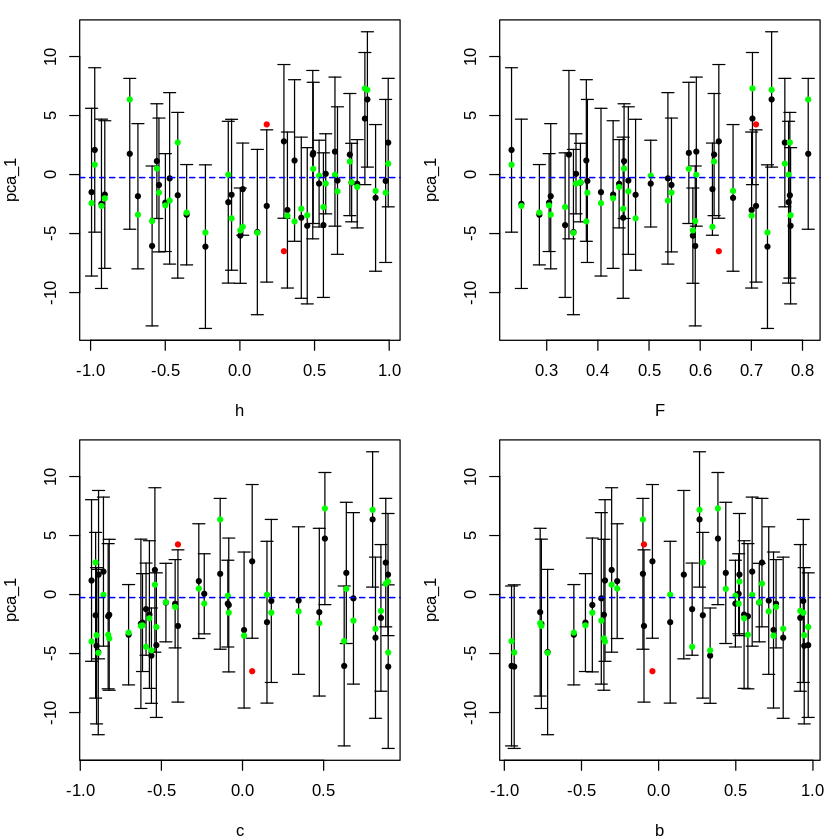

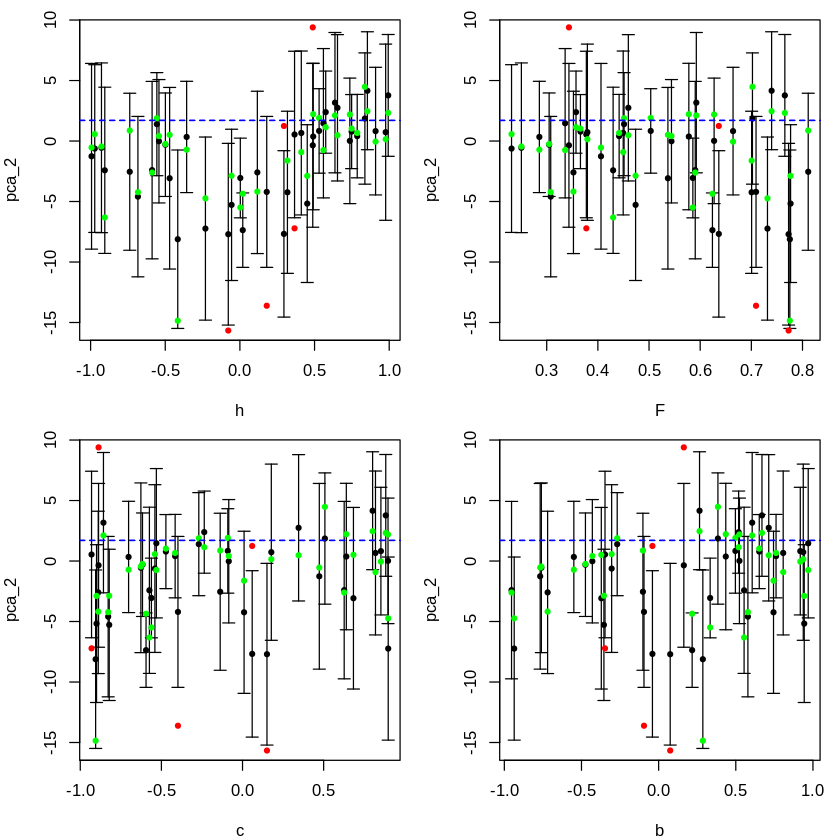

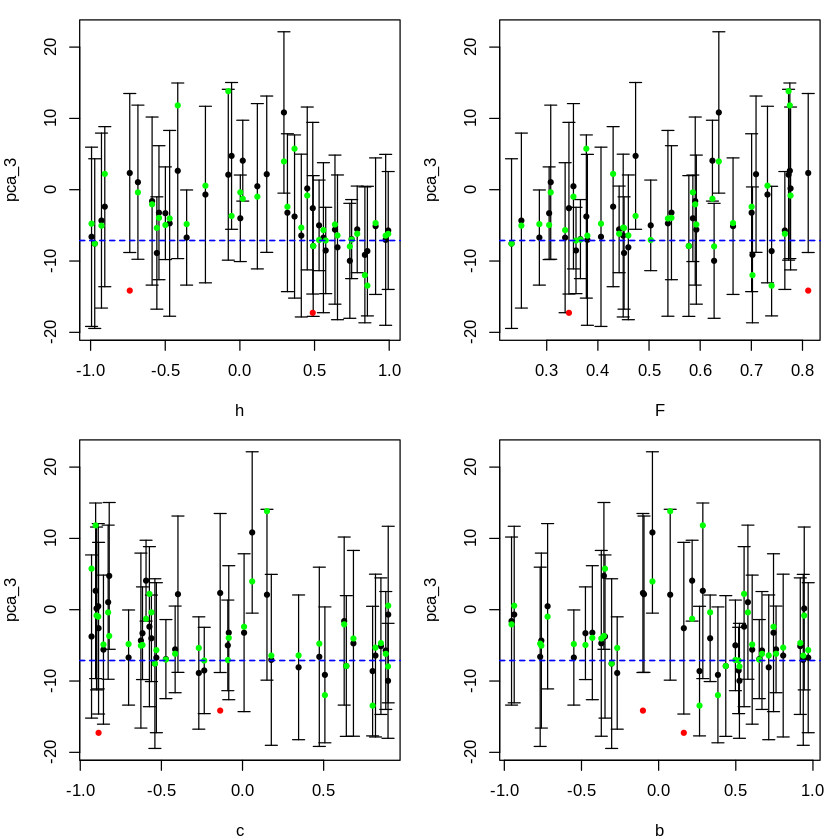

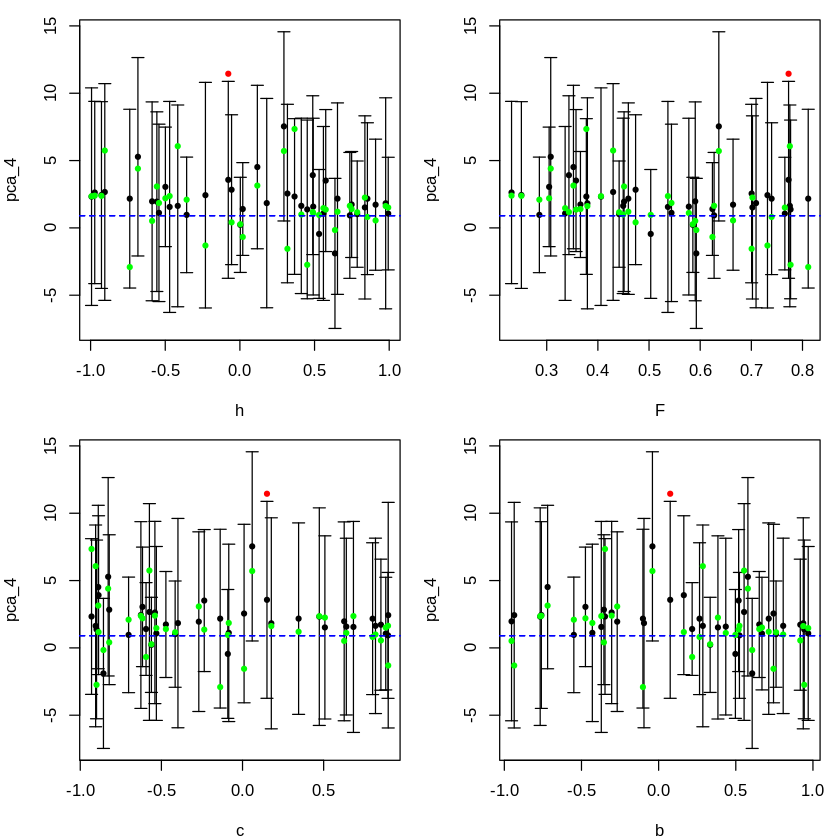

In [41]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [42]:
Timps3 <- matrix(rep(t(Timps2),1), ncol=ncol(Timps2), byrow=TRUE)
system.time(Timps3[NROY2,] <- ImplausibilityMOGP(NewData=Xp[NROY2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  1.304   3.721   1.347 

In [43]:
ImpData_wave3 = cbind(Xp, Timps3)

In [44]:
valmax3 = 0 #how many outputs can be above the implausibility cut off?
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=TestEm3$mogp$n_emulators, whichMax=valmax3+1)
NROY3 <- which(rowSums(Timps3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax3)
ratio3 <- length(NROY3)/dim(Xp)[1]
ratio3

[1] 0.055526

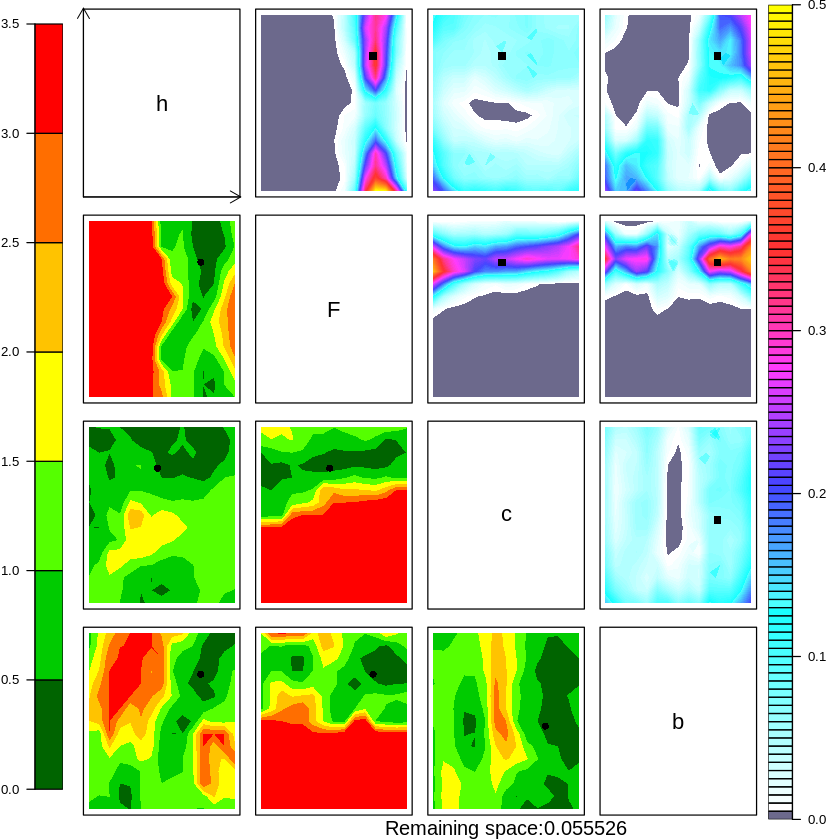

In [45]:
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY3)/dim(Xp)[1],sep=""), side=1)

In [46]:
length(NROY3)

[1] 55526

## wave 4

In [47]:
40/ratio3

[1] 720.3832

In [48]:
set.seed(42)

designpoints3 <- data.frame()

while (nrow(designpoints3) <= 40) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio3), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints3 <- rbind(designpoints3,selectionP)
        print(nrow(designpoints3))
        flush.console()
        } 

designpoints3 <- designpoints3[sample(nrow(designpoints3),40),]

designpoints_denorm3 <- rangeUnscale(designpoints3, my_bounds)

[1] 37
[1] 82


In [49]:
write.csv(designpoints_denorm3,"Data/exp_TuningL94_newPCA_wave4.csv", row.names = FALSE)

In [50]:
designpoints3

,h,F,c,b
,<dbl>,<dbl>,<dbl>,<dbl>
20,-0.760908166,0.1955528,-0.88257461,0.4211430
39,-0.283543256,0.6235240,0.29516221,-0.3520600
80,-0.745488982,0.8104635,0.90212268,-0.1478227
9,-0.167017997,0.8031810,0.72312946,-0.3806099
46,0.693780946,0.4694235,0.06771007,0.8055181
74,0.530926814,0.3419801,-0.50058301,0.4245579
60,-0.633058532,0.5627636,0.91865806,-0.7027711
28,0.718564919,0.4210954,-0.65120746,0.6308314
40,-0.821369084,0.7025886,0.62574182,-0.7321102


In [51]:
#### if one of the configs has a b that is too close to zero
#### designpoints3 <- designpoints3[!abs(designpoints3$b) < 1e-3,]

In [52]:
inputs <- designpoints3

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_wave4.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,-0.7609082,0.1955528,-0.88257461,0.4211430,0.68547922,-3.572562,-3.3506901,-2.01850246,-1.076671062,4.4424318,-0.2201597,-1.5821130,0.1744368
39,-0.2835433,0.6235240,0.29516221,-0.3520600,-0.28234909,9.640835,-2.9808922,-0.52419188,-2.757027602,0.6966263,1.7499495,0.5937773,-0.3710000
80,-0.7454890,0.8104635,0.90212268,-0.1478227,0.18156421,-2.235438,2.9123701,0.57233131,-11.177390462,-1.7958704,-2.6942919,3.2327248,-1.6668484
9,-0.1670180,0.8031810,0.72312946,-0.3806099,0.31643130,12.937137,-4.4101226,-2.31414103,0.009683775,-1.7851098,3.2058895,1.2747063,-0.3734124
46,0.6937809,0.4694235,0.06771007,0.8055181,0.20213416,5.968417,-1.7586332,0.06565255,-5.850569341,1.0588660,0.5843700,1.0557025,-0.6012005
74,0.5309268,0.3419801,-0.50058301,0.4245579,-0.05306226,2.657717,-0.1284857,1.76493902,-7.399338073,1.3811462,-0.6915290,0.8004886,-0.6792135


In [53]:
TestEm4 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.824597711384213 using F"
[1] "Max reduction is 0.610492684355833 using h"
[1] "Max reduction is 0.284649544417739 using b"
[1] "Max reduction is 0.405052191004581 using b"
[1] "Max reduction is 0.112478702710321 using Three Way Interactions with b"
[1] "Max reduction is 0.122388082229725 using c"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ F + h + b + I(b^2) + c + I(h * F) + I(b * 
    F) + I(c * F) + I(b * h) + I(c * h) + I(c * b) + I(b * h * 
    F) + I(b * b * F) + I(b * c * F) + I(b * b * h) + I(b * c * 
    h) + I(b * c * b), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7827 -0.6521  0.1417  0.5236  3.8396 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -8.8581     3.9818  -2.225 0.036679 *  
F             27.6491     6.8399   4.042 0.000544 ***
h            -11.2139     7.0127  -1.599 0.124066    
b             23.9872    11.7111   2.048 0.052654 .  
I(b^2)       -27.9231  

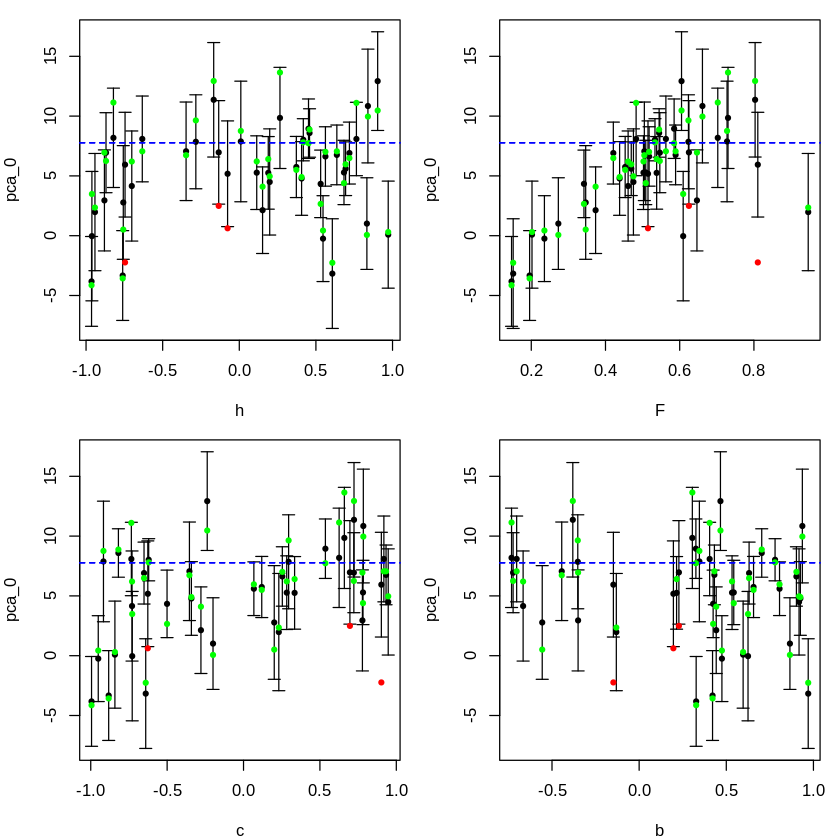

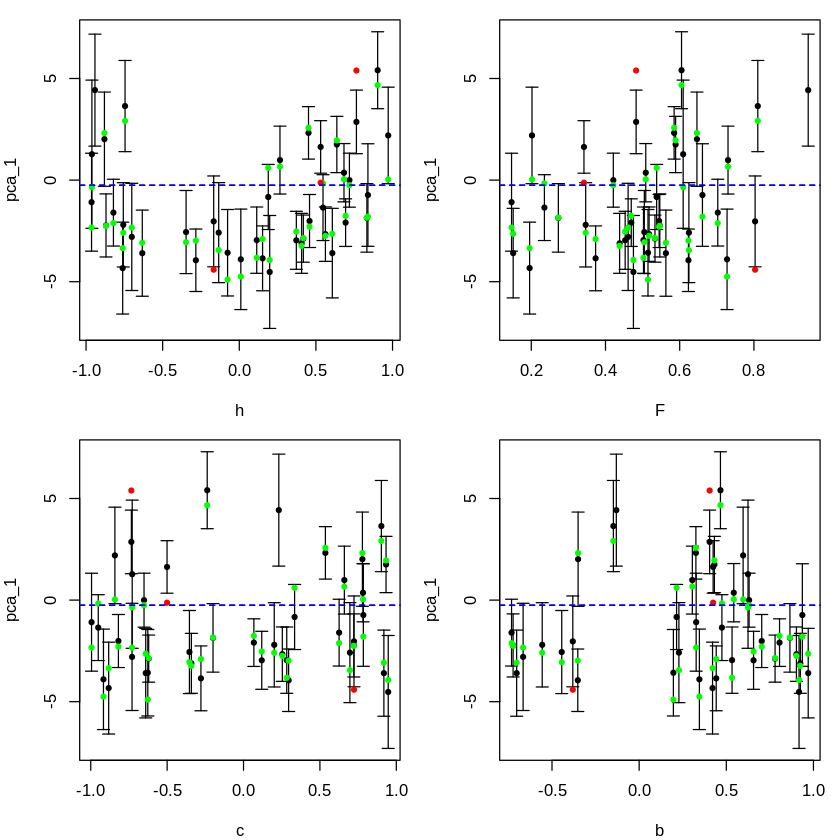

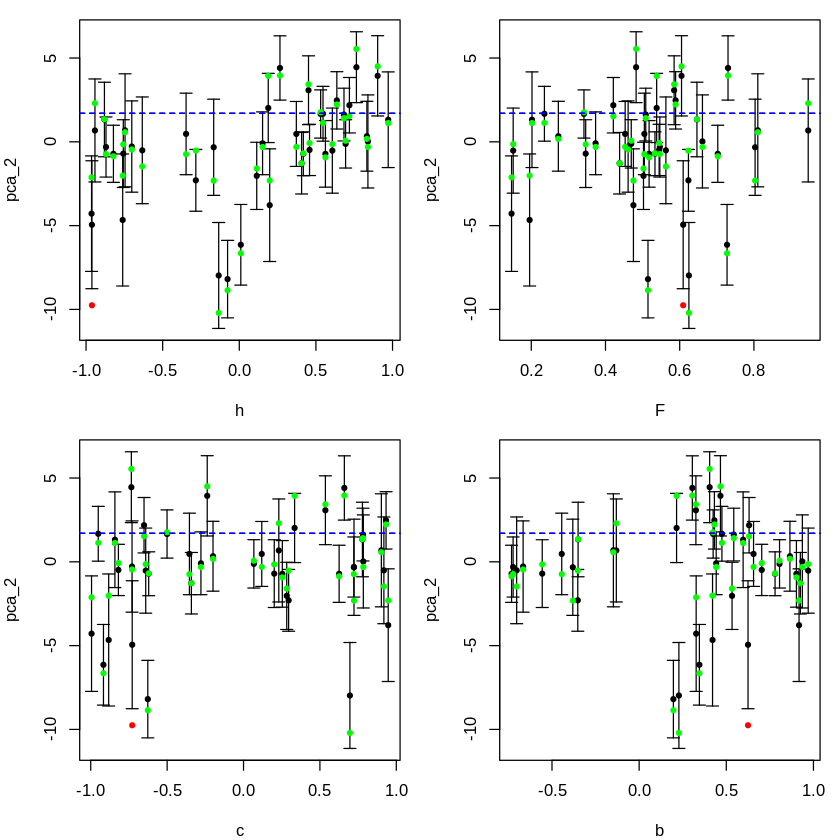

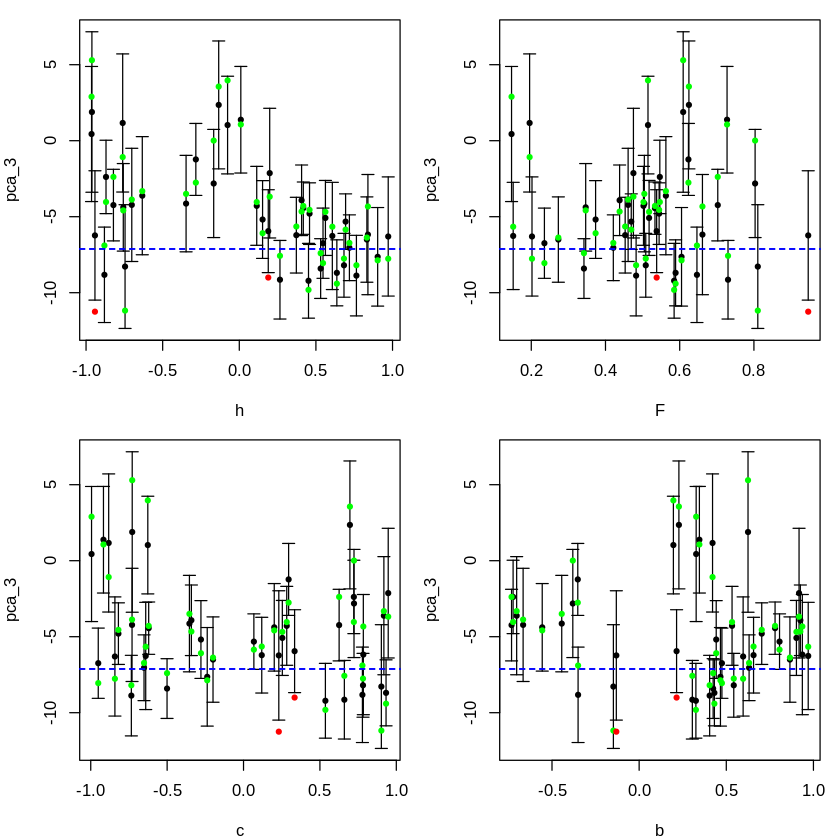

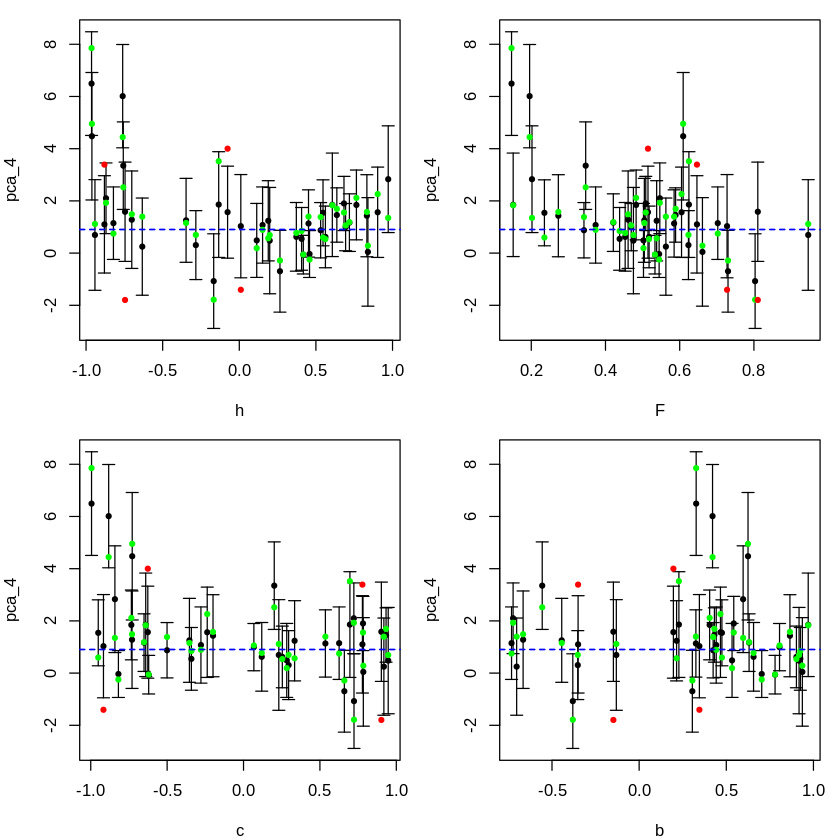

In [54]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [55]:
Timps4 <- matrix(rep(t(Timps3),1), ncol=ncol(Timps3), byrow=TRUE)
system.time(Timps4[NROY3,] <- ImplausibilityMOGP(NewData=Xp[NROY3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.944   4.228   1.489 

In [56]:
ImpData_wave4 = cbind(Xp, Timps4)

In [57]:
valmax4 = 0 #how many outputs can be above the implausibility cut off?
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=TestEm4$mogp$n_emulators, whichMax=valmax4+1)
NROY4 <- which(rowSums(Timps4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax4)
ratio4 <- length(NROY4)/dim(Xp)[1]
ratio4

[1] 0.023116

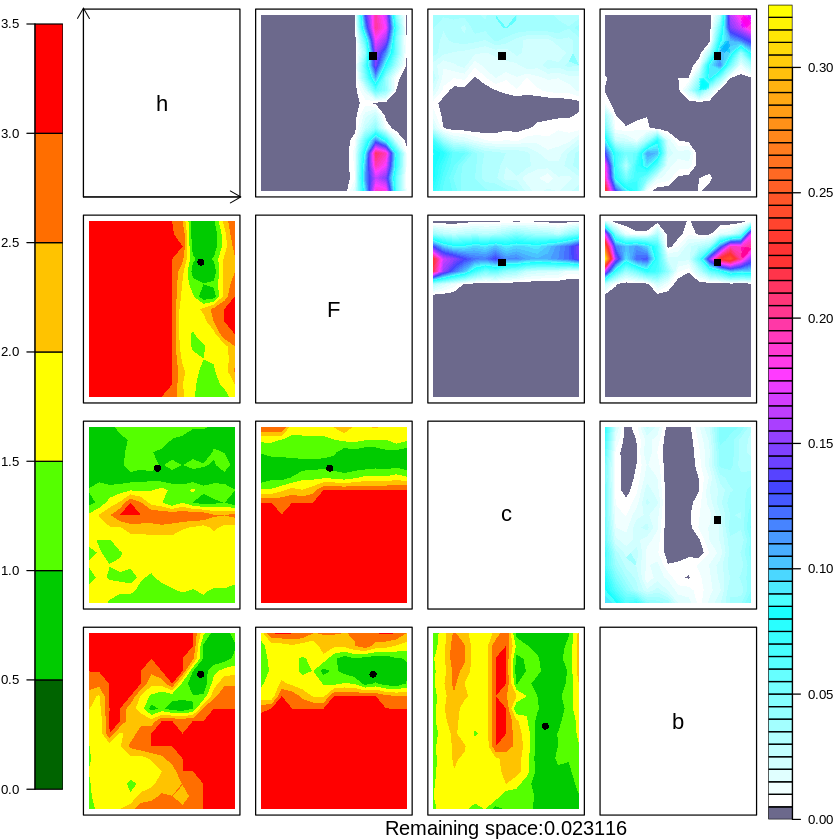

In [58]:
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY4)/dim(Xp)[1],sep=""), side=1)

In [59]:
length(NROY4)

[1] 23116

## wave 5

In [60]:
40/ratio4

[1] 1730.403

In [61]:
set.seed(42)

designpoints4 <- data.frame()

while (nrow(designpoints4) <= 40) {
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio4), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        ### Emulator wave 4
        imps_tmp4 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp4 <- which(rowSums(imps_tmp4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints4 <- rbind(designpoints4,selectionP)
        print(nrow(designpoints4))
        flush.console()
        } 

designpoints4 <- designpoints4[sample(nrow(designpoints4),40),]

designpoints_denorm4 <- rangeUnscale(designpoints4, my_bounds)

[1] 45


In [62]:
write.csv(designpoints_denorm4,"Data/exp_TuningL94_newPCA_wave5.csv", row.names = FALSE)

In [63]:
inputs <- designpoints4

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_wave5.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.1084131,0.6576162,0.7529655,0.2571261,0.68547922,12.373143,-2.3323852,2.0624217,-6.102281,-1.3141766,2.1971872,1.7854811,-0.7891471
9,0.6551930,0.5745313,0.7552529,0.5399900,-0.28234909,5.768351,0.1991901,1.7803668,-7.463763,1.3402715,-0.5301122,0.9662593,-0.6376439
20,0.9170097,0.7094841,0.8629641,0.8284860,0.18156421,11.284651,-0.6292600,0.6533193,-4.932782,0.6501202,0.6151435,0.9616777,-0.4551458
10,0.1326062,0.5932379,0.2262143,0.1908568,0.31643130,12.808453,0.6709748,5.1266266,-9.717770,-0.6002134,0.5383569,1.8700220,-0.8713795
31,0.8587791,0.3966182,0.4833394,0.9878674,0.20213416,2.872701,-2.0506417,-0.2280345,-6.060088,1.5372820,0.3203929,0.8985923,-0.6341841
5,0.3234978,0.6906960,0.7929720,0.5455103,-0.05306226,11.524667,-2.3155530,0.1785312,-4.413871,-0.8440947,1.8795705,1.5879608,-0.6047579


In [64]:
TestEm5 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 1.12486429996579 using F"
[1] "Max reduction is 0.0653987271767225 using h"
[1] "Max reduction is 0.337509025113717 using b"
[1] "Max reduction is 0.484766388206308 using c"
[1] "Max reduction is 0.116998915320663 using h"
[1] "Max reduction is 0.249335988351128 using Three Way Interactions with h"
[1] "Max reduction is 0.0301796079973391 using b"
[1] "Max reduction is 0.0820345472414044 using b"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ F + h + I(h^2) + b + I(b^2) + I(b^3) + c + 
    I(h * F) + I(b * F) + I(c * F) + I(b * h) + I(c * h) + I(c * 
    b) + I(h * h * F) + I(h * b * F) + I(h * c * F) + I(h * b * 
    h) + I(h * c * h) + I(h * c * b), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8993 -0.5972  0.0930  0.5740  2.9013 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -8.384      5.198  -1.613  0.12243   
F              31.729      8.691   3.651 

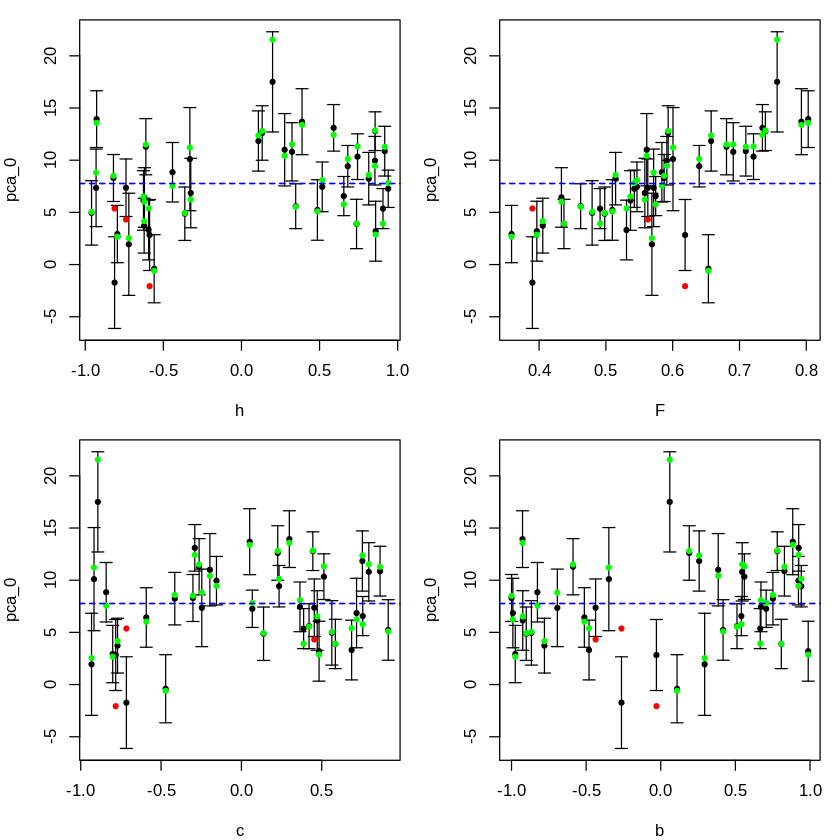

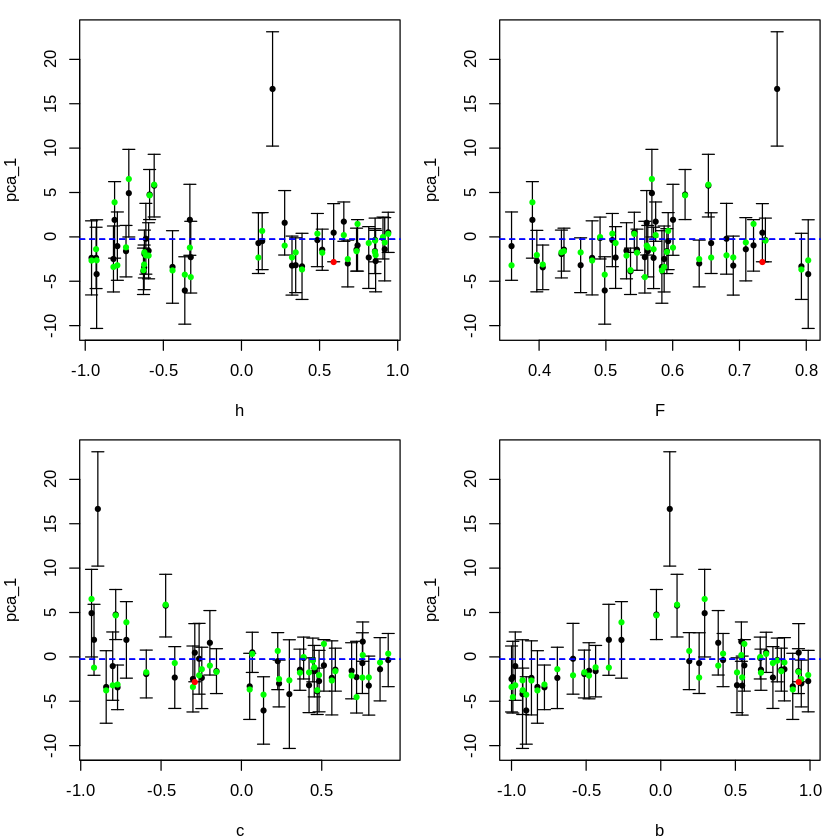

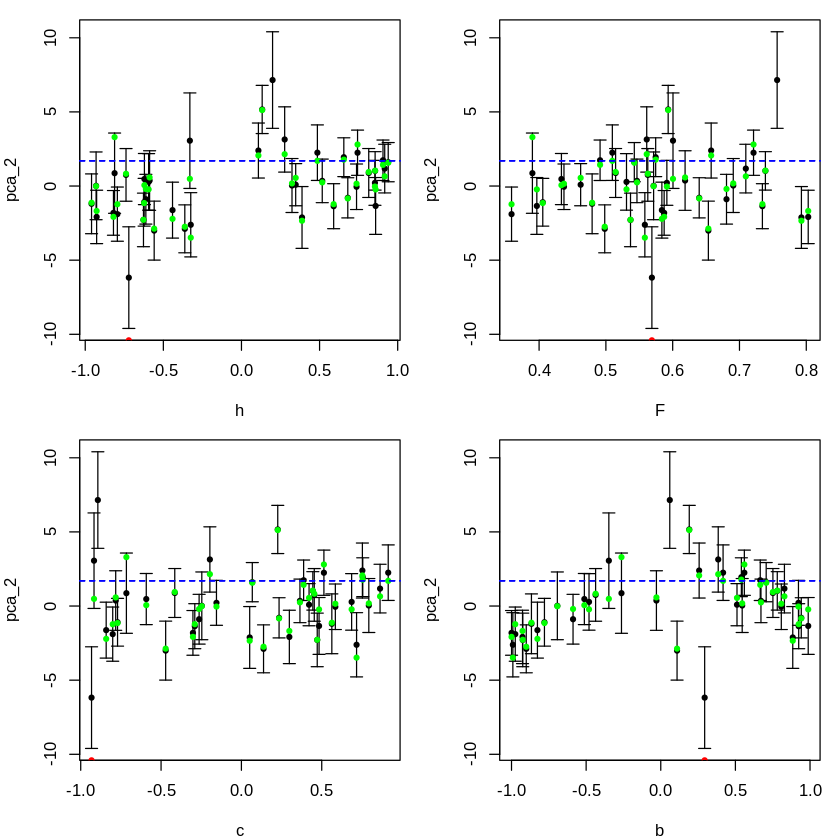

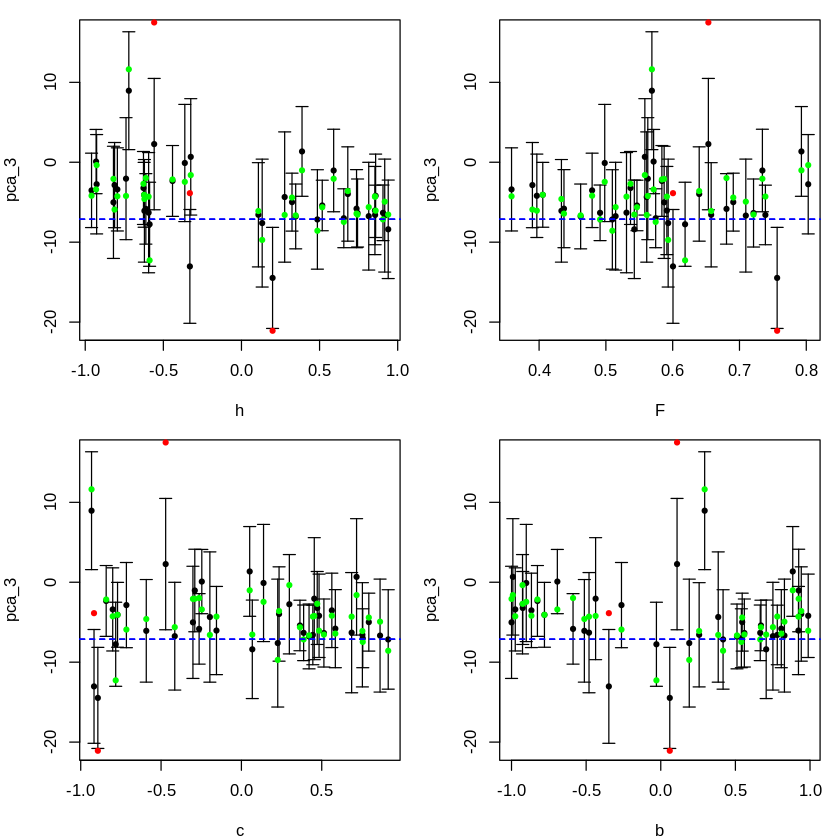

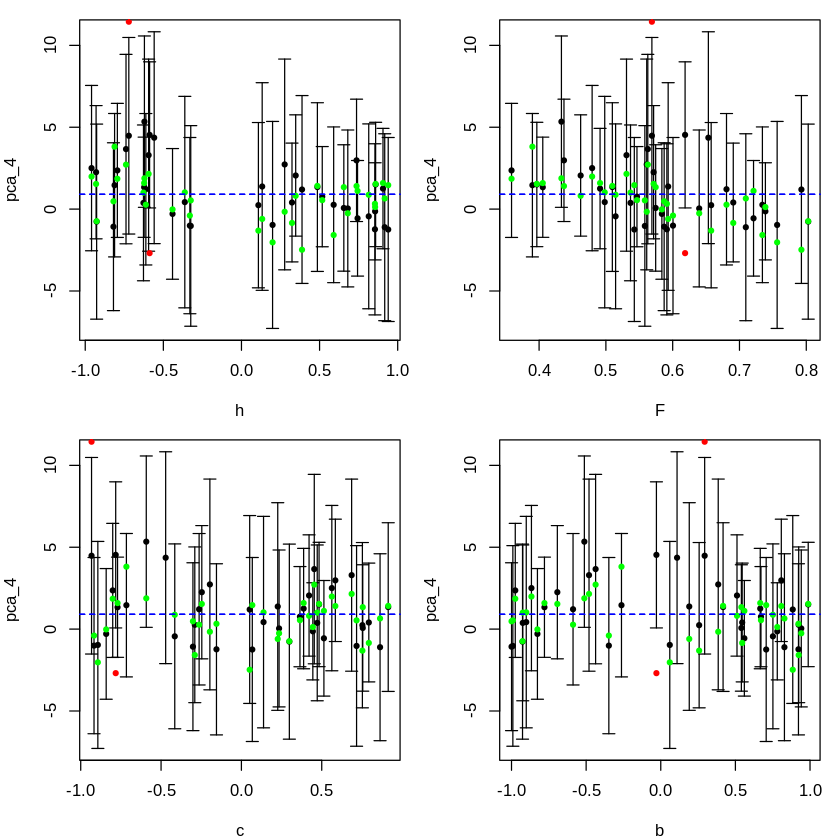

In [65]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [66]:
Timps5 <- matrix(rep(t(Timps4),1), ncol=ncol(Timps4), byrow=TRUE)
system.time(Timps5[NROY4,] <- ImplausibilityMOGP(NewData=Xp[NROY4,], Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.512   4.649   1.501 

In [67]:
ImpData_wave5 = cbind(Xp, Timps5)

In [68]:
valmax5 = 0 #how many outputs can be above the implausibility cut off?
ImpListM5 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave5, nEms=TestEm5$mogp$n_emulators, whichMax=valmax5+1)
NROY5 <- which(rowSums(Timps5 <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5)
ratio5 <- length(NROY5)/dim(Xp)[1]
ratio5

[1] 0.009407

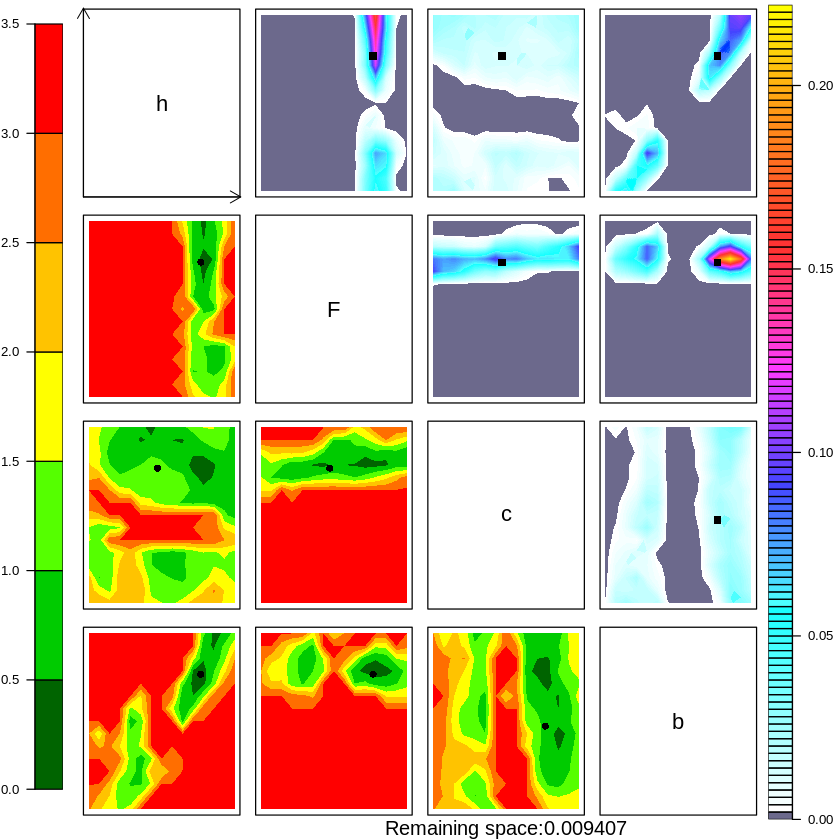

In [69]:
imp.layoutm11(ImpListM5,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY5)/dim(Xp)[1],sep=""), side=1)

## wave 6

In [70]:
40/ratio5

[1] 4252.153

In [71]:
set.seed(42)

designpoints5 <- data.frame()

############ SWITCH TO RANDOM LHS because it takes so much time !!!!!! ####################

while (nrow(designpoints5) < 40) {
        ### Emulator wave 1
        tmp <- as.data.frame(2*randomLHS(ceil(40/ratio5), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        ### Emulator wave 4
        imps_tmp4 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp4 <- which(rowSums(imps_tmp4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax)
        ### Emulator wave 5
        imps_tmp5 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,], Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp5 <- which(rowSums(imps_tmp5 <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,][NROYtmp5,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints5 <- rbind(designpoints5,selectionP)
        print(nrow(designpoints5))
        flush.console()
        } 

designpoints5 <- designpoints5[sample(nrow(designpoints5),40),]

designpoints_denorm5 <- rangeUnscale(designpoints5, my_bounds)

[1] 47


In [72]:
write.csv(designpoints_denorm5,"Data/exp_TuningL94_newPCA_wave6.csv", row.names = FALSE)

In [73]:
inputs <- designpoints5

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_wave6.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.8671225,0.4444929,-0.94425351,0.6754792,0.68547922,8.332717,0.3919408,1.92605730,-6.179835,1.0625908,-0.3423246,0.7697331,-0.5173480
9,0.6438285,0.4508000,-0.69966533,0.6323737,-0.28234909,7.430825,-0.6288061,1.40690587,-6.300509,0.8894612,0.2081466,0.9866432,-0.6059935
11,0.8206030,0.4057918,-0.36891847,0.8962947,0.18156421,4.768702,-1.7768449,0.01028002,-5.921287,1.3021614,0.4048399,0.9216885,-0.5324097
38,0.4722665,0.5085448,-0.52135097,0.6219158,0.31643130,8.275560,-1.6789328,0.62742557,-5.531426,0.3139678,0.9673696,1.1795301,-0.5315369
43,0.7529699,0.5624814,-0.08896199,0.6228200,0.20213416,9.585824,0.4025149,1.87080873,-6.412367,1.0417409,-0.1319111,0.8504695,-0.4046233
30,0.8143343,0.7191888,0.93334329,0.6451451,-0.05306226,9.738343,0.5402418,1.88867357,-6.344992,1.1744990,-0.2178333,0.8321138,-0.4487270


In [74]:
TestEm6 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.774528321406624 using F"
[1] "Max reduction is 0.396353284104346 using c"
[1] "Max reduction is 0.0579393804057515 using h"
[1] "Max reduction is 0.0293129475980171 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = pca_0 ~ F + c + h + b + I(c * F) + I(h * F) + I(b * 
    F) + I(h * c) + I(b * c) + I(b * h), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4802 -0.1871  0.0296  0.3172  1.3223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.0091     1.4917  -3.358  0.00221 ** 
F            24.5750     3.0567   8.040 7.25e-09 ***
c            -0.7570     1.4557  -0.520  0.60699    
h            10.8496    11.6416   0.932  0.35905    
b           -14.7203    13.1284  -1.121  0.27138    
I(c * F)     -2.9038     2.7217  -1.067  0.29482    
I(h * F)    -19.3064    22.2348  -0.868  0.39236    
I(b * F)     27.2618    25.1294   1.085  0.28692    
I(h * c)     -2.1042     2.3117  -0.910  0.3702

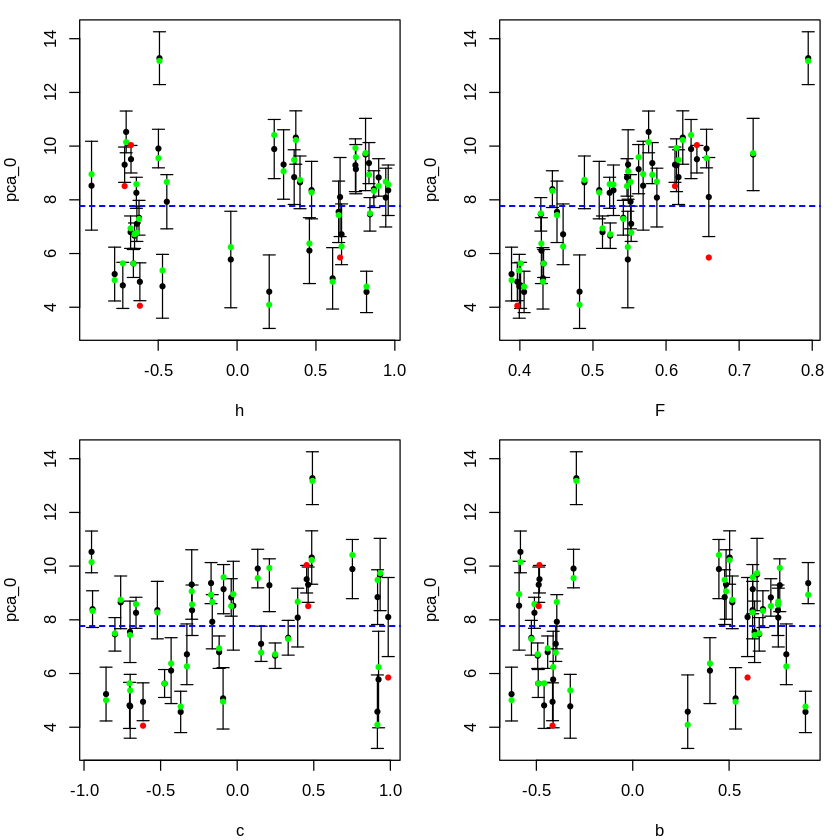

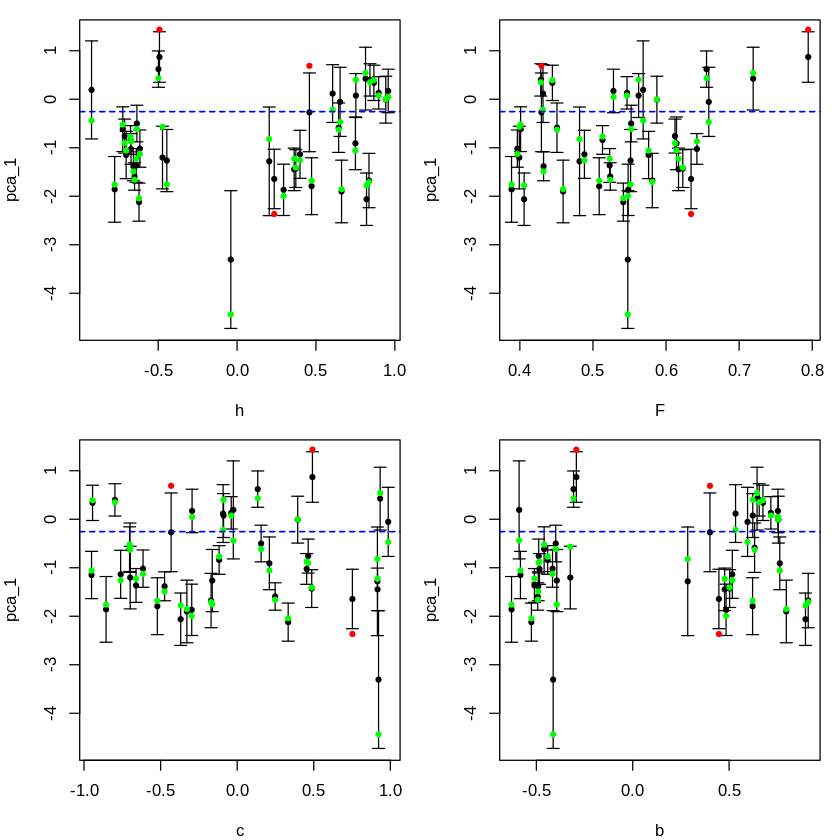

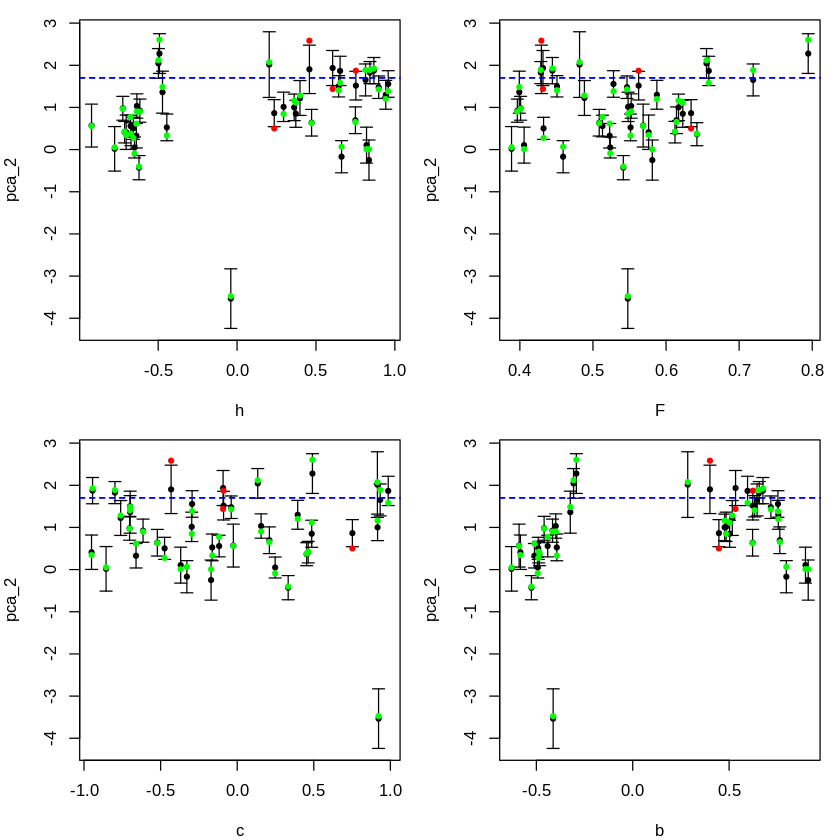

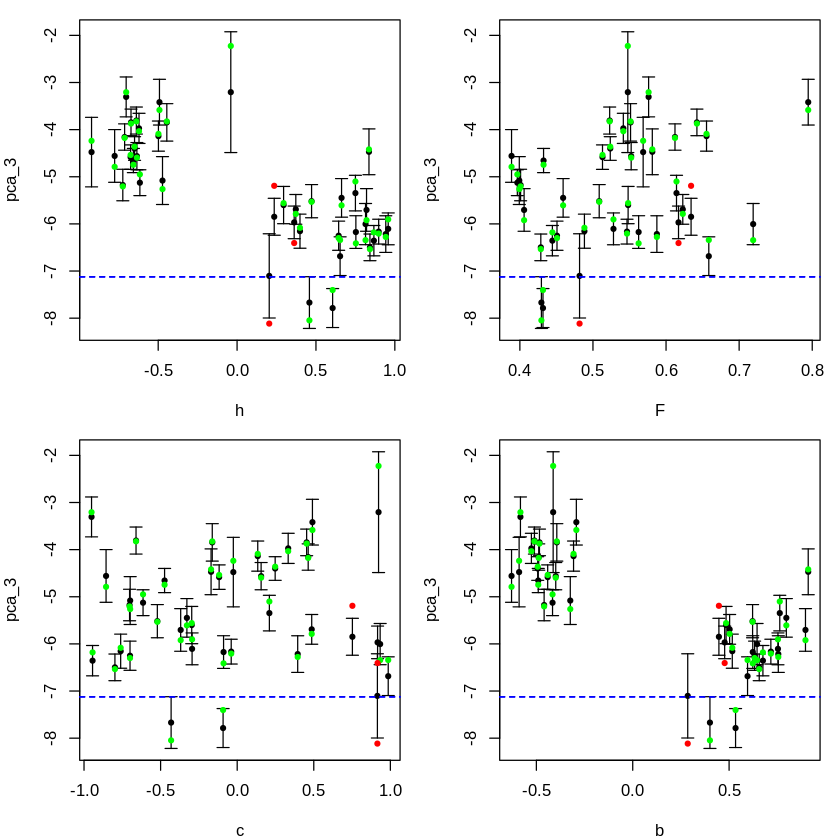

ERROR: Error in readBin(tf, raw(), file.info(tf)$size): vector size cannot be NA/NaN


Plot with title “”

In [75]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [76]:
Timps6 <- matrix(rep(t(Timps5),1), ncol=ncol(Timps5), byrow=TRUE)
system.time(Timps6[NROY5,] <- ImplausibilityMOGP(NewData=Xp[NROY5,], Emulator=TestEm6, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.238   4.314   1.572 

In [77]:
ImpData_wave6 = cbind(Xp, Timps6)

In [78]:
valmax6 = 0 #how many outputs can be above the implausibility cut off?
ImpListM6 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave6, nEms=TestEm6$mogp$n_emulators, whichMax=valmax6+1)
NROY6 <- which(rowSums(Timps6 <= cutoff_vec[1]) >= TestEm6$mogp$n_emulators -valmax6)
ratio6 <- length(NROY6)/dim(Xp)[1]
ratio6

[1] 0.00024

In [82]:
png("InputSpace_wave_6.png", res = 110)
imp.layoutm11(ImpListM6,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY6)/dim(Xp)[1],sep=""), side=1)
dev.off()

png 
  2

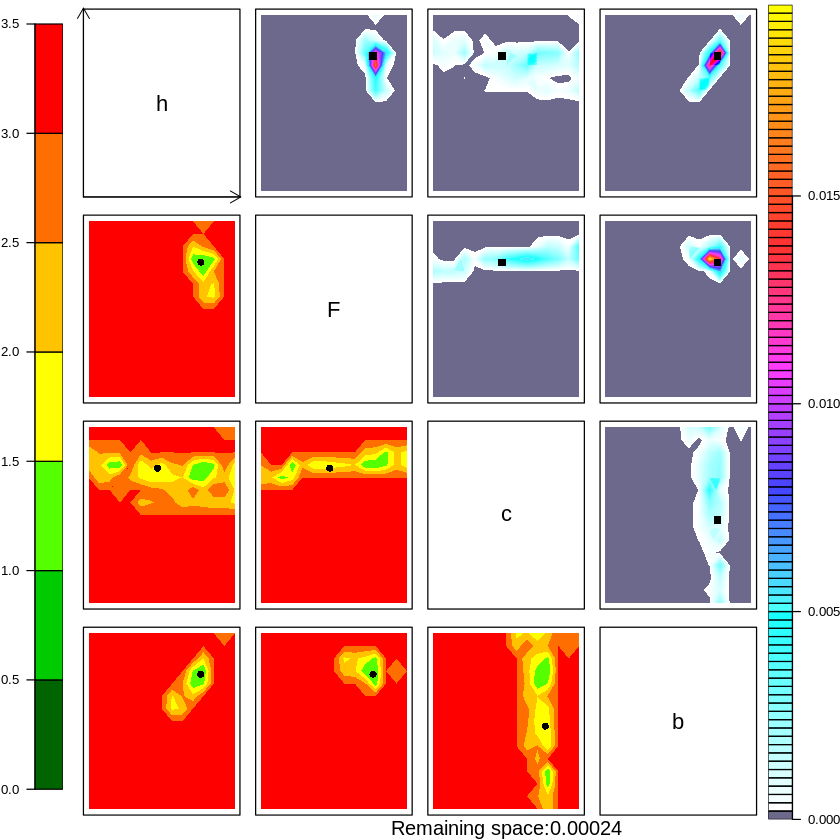

In [79]:
imp.layoutm11(ImpListM6,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY6)/dim(Xp)[1],sep=""), side=1)

In [80]:
#imp.layoutm11(ImpListM6,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=rbind(matrix(param.defaults.norm,ncol=nparam),as.matrix(sapply(kmcenters, as.numeric))))
#mtext(paste("Remaining space:",length(NROY6)/dim(Xp)[1],sep=""), side=1)

In [81]:
length(NROY6)

[1] 240

## K-means

In [79]:
library(ClusterR)

Loading required package: gtools


Attaching package: ‘gtools’


The following object is masked from ‘package:pracma’:

    logit




In [80]:
preProcValues <- preProcess(Xp[NROY6,], method = c("center", "scale"))
normalizeddata <- predict(preProcValues, Xp[NROY6,])

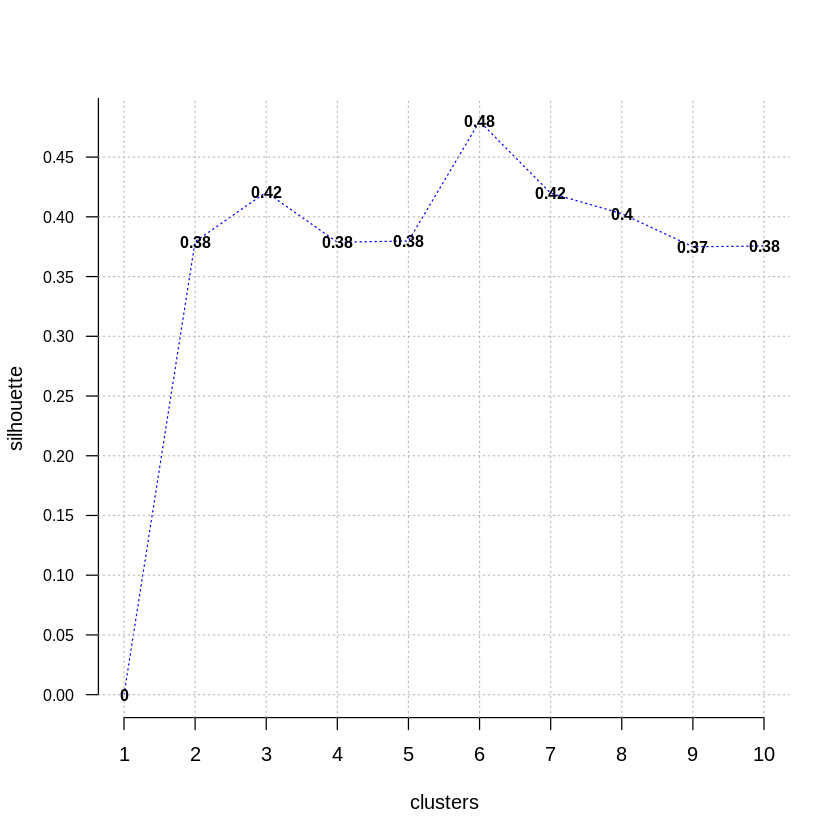

In [81]:
opt_km = Optimal_Clusters_KMeans(normalizeddata, criterion = "silhouette", max_clusters=10, plot_clusters = TRUE)

In [92]:
opt_km

 [1] 0.0000000 0.3792117 0.4206909 0.3787124 0.3797616 0.4799264 0.4198088
 [8] 0.4026423 0.3749228 0.3755933
attr(,"class")
[1] "k-means clustering"

In [82]:
classif <- kmeans(normalizeddata, centers=6, iter.max=100, nstart=100)
kmcenters <- unPreProc(preProcValues, data.frame(classif$centers))
candidates <- rangeUnscale(kmcenters, my_bounds)
candidates

,h,F,c,b
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3068263,11.591875,18.068481,4.316236
2,0.9886573,11.898400,16.208397,9.168807
3,1.1525103,8.935878,3.935651,10.333389
4,0.5769898,10.310550,11.899110,6.890702
5,0.9217106,10.312897,10.275562,9.352181
6,1.8693471,11.522204,19.033968,15.654917


In [83]:
library(xtable)

print.xtable(xtable(candidates))


Attaching package: ‘xtable’


The following object is masked from ‘package:spam’:

    display




% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Sun Nov 20 19:52:57 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & h & F & c & b \\ 
  \hline
1 & 0.31 & 11.59 & 18.07 & 4.32 \\ 
  2 & 0.99 & 11.90 & 16.21 & 9.17 \\ 
  3 & 1.15 & 8.94 & 3.94 & 10.33 \\ 
  4 & 0.58 & 10.31 & 11.90 & 6.89 \\ 
  5 & 0.92 & 10.31 & 10.28 & 9.35 \\ 
  6 & 1.87 & 11.52 & 19.03 & 15.65 \\ 
   \hline
\end{tabular}
\end{table}


# Ensemble of plausible simulations

In [84]:
### check if Kmeans centers are in NROY6
imps_kmeans <- ImplausibilityMOGP(NewData=kmcenters, Emulator=TestEm6, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
which(rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm6$mogp$n_emulators -valmax6)

[1] 2 3 4 5 6

In [85]:
testpoints <- rangeUnscale(kmcenters, my_bounds)[rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm6$mogp$n_emulators -valmax6,]

In [86]:
write.csv(testpoints,"Data/finaltestpoints_newPCA.csv", row.names = FALSE)

## summary of the HM

In [87]:
ratio1

[1] 0.16956

In [88]:
NROYs <- 100 * c(ratio1, ratio2, ratio3, ratio4, ratio5, ratio6)
NbSim <- c(40, nrow(designpoints), nrow(designpoints2), nrow(designpoints3), nrow(designpoints4), nrow(designpoints5))

In [89]:
data.frame(NROYs, NbSim)

NROYs,NbSim
<dbl>,<dbl>
16.9560,40
7.9141,40
5.5526,40
2.3116,40
0.9407,40
0.0240,40


In [90]:
#print.xtable(xtable(data.frame(NROYs, NbSim)))

In [91]:
sum(NbSim)

[1] 240